**Sep 8, 2024 -  I improved the indexing and product comparison methods in this notebook. I tested on Mac OS, but still need to test on Linux....**

# AiZynthFinder Retrosynthesis Reaction Prediction

V.F. Scalfani and A.M. Fernandez, University of Alabama Libraries

Fall 2024 

## Anticipated Length of Workshop

1 hour

## What is the purpose of this workshop?

This workshop will introduce the open-source AiZynthFinder retrosynthetic software (https://github.com/MolecularAI/aizynthfinder). AiZynthFinder includes a GUI version, a command-line version, and a Python interface. We will look at all three, but will spend the most time using the Python interface.

## Brief Description of Method

AiZynthFinder uses a reaction template-based approach for prediction. First, reaction templates (Reaction SMARTS patterns) are extracted from a large dataset of USPTO patent reactions (~1 million unique reactions). A neural network is then trained with the reactions and reaction templates (this training "learns" which transformations are associated with specific products/reactants). A Monte Carlo tree search algorithm (similar to Segler et al., 2018) is used to deconstruct target molecules into precursors and each pathway is guided by the neural network; that is, the neural network is used to prioritize and select a small subset of the most probable reaction templates to apply (< 50). Finally, a library of purchasable compounds is factored into the paths, where for example, the path can be considered complete if all precursors are commercially available (Thakkar et al 2020 and Genheden, S. et al. 2020).

In order to succesfully use AiZynthFinder, we need a basic understanding of some of the AI/ML terminology used in the configuration files and functions:

1. Expansion Policy - This refers to the neural network used to identify the most probable application of templates. There are two public models available within the AiZynthFinder package: (1) "USPTO" model trained on the USPTO patent reactions and "Ring Breaker", which is a model also trained on USPTO data, but optimized for prediction of ring system formations (Thakkar, A.; Selmi, N. et al. 2020 and Thakkar, A.; Kogej, T. et al. 2020).

2. Stock Policy - Collection of commercially available small molecules. AiZynthFinder has a collection from the ZINC database readily available for download.

3. Filter Policy - A filter policy is optional. This is a model that incorporates virtually created unfeasible reactions and is used to identify and eliminate unfeasible routes. AiZynthFinder has a public filter policy trained from USPTO (Genheden, S. 2020, ChemRXiv).

## References

* Thakkar, A.; Selmi, N.; Reymond, J.-L.; Engkvist, O.; Bjerrum, E. J. “Ring Breaker”: Neural Network Driven Synthesis Prediction of the Ring System Chemical Space. J. Med. Chem. 2020, 63 (16), 8791–8808. https://doi.org/10.1021/acs.jmedchem.9b01919.
* Thakkar, A.; Kogej, T.; Reymond, J.-L.; Engkvist, O.; Bjerrum, E. J. Datasets and Their Influence on the Development of Computer Assisted Synthesis Planning Tools in the Pharmaceutical Domain. Chem. Sci. 2020, 11 (1), 154–168. https://doi.org/10.1039/C9SC04944D.
* Genheden, S.; Thakkar, A.; Chadimová, V.; Reymond, J.-L.; Engkvist, O.; Bjerrum, E. AiZynthFinder: A Fast, Robust and Flexible Open-Source Software for Retrosynthetic Planning. J Cheminform 2020, 12 (1), 70. https://doi.org/10.1186/s13321-020-00472-1.
* Genheden, S.; Engkvist, O.; Bjerrum, E. J. A Quick Policy to Filter Reactions Based on Feasibility in AI-Guided Retrosynthetic Planning. November 25, 2020. https://doi.org/10.26434/chemrxiv.13280495.v1.
* Segler, M. H. S.; Preuss, M.; Waller, M. P. Planning Chemical Syntheses with Deep Neural Networks and Symbolic AI. Nature 2018, 555 (7698), 604–610. https://doi.org/10.1038/nature25978.
* AiZynthFinder Docs: https://molecularai.github.io/aizynthfinder/



## Local Setup for Python Environment

Here is a conda environment recipe (this installs RDKit, Jupyter, and everything we should need for today):

Linux:

```
conda create --name retro_aizynth_env
conda activate retro_aizynth_env
conda install -c conda-forge "python>=3.9,<3.11" "numpy<2.0" pip
pip install aizynthfinder[all]

```

For Mac, use the following recipe and note that with zsh shell, wrap the aizynthfinder[all] in quotes:

```
conda create --name retro_aizynth_env
conda activate retro_aizynth_env
conda install -c conda-forge "python>=3.9,<3.11" "numpy<2.0" pip jq
pip install 'aizynthfinder[all]'

```


## Download the Public Models and Datasets

In [1]:
# make a directory for aizynth data folder (if not already created)
import os

# Path to the folder expected
folder_path = 'aizynth_data'

# Check if the folder exists
if not os.path.exists(folder_path):
    # Create the folder if it does not exist
    os.makedirs(folder_path)
    print(f"Folder created: {folder_path}")
else:
    print("Folder already exists.")

Folder already exists.


In [2]:
# Download the AiZynth models and data (if needed)
# !download_public_data aizynth_data
import os
import subprocess
import glob

# Path to the folder expected
folder_path = 'aizynth_data'

# Check if the folder exists
if not os.path.exists(folder_path):
    # Terminate if no folder
    print(f"Terminated, {folder_path} folder not found, see cell above to create.")
else:
    # Check for some Aizynthfiles already existing'
    uspto_files = glob.glob(os.path.join(folder_path, 'uspto*'))
    zinc_files = glob.glob(os.path.join(folder_path, 'zinc*'))
    con_file = glob.glob(os.path.join(folder_path, 'config*'))

    if uspto_files and zinc_files and con_file:
        # Terminate if these files are already downloaded
        print("Terminated, files starting with 'uspto', 'zinc', and 'config' are already present.")
    else:
        # If the files are not there, download the files using subprocess
        print("Downloading files...")
        # `download_public_data folder_path` is an aizynthfinder command line program
        subprocess.run(["download_public_data", folder_path])

Terminated, files starting with 'uspto', 'zinc', and 'config' are already present.


In [3]:
# Now CD to aizynth_data folder
import os
os.chdir('aizynth_data')

## GUI Version

*Some terminology and GUI figure notes:*

**State score** - "The score reflects the fraction of solved precursors and
the number of reactions required to synthesize the target compound.
The score for a solved compound is close
to 1.0, whereas the score for an unsolved compound is
typically less than 0.8. However, it should be noted that
the score was designed to support the tree search and
is rather indiscriminate with regard to the quality of the
route (i.e. if it's a good route or not) and should be interpreted with care. (Genheden, S.; et al.J Cheminform 2020, 12 (1), 70. https://doi.org/10.1186/s13321-020-00472-1.)"

**Green Box** - precursor available in Zinc

**Orange Box** - precursor not available in Zinc

Here are some example targets to try (copy/paste into GUI when loaded):

```
# from the AiZynth Docs
Cc1cccc(c1N(CC(=O)Nc2ccc(cc2)c3ncon3)C(=O)C4CCS(=O)(=O)CC4)C

# from PubChem, CID 10615
CC(=O)N(C1=CC=CC=C1)C2=CC=CC=C2

# from PubChem, CID 2854
CCC(C)C(=O)OC1CCC=C2C1C(C(C=C2)C)CCC3CC(CC(=O)O3)O

# from Thakkar, A. et al. J. Med. Chem. 2020, 63 (16), 8791. https://doi.org/10.1021/acs.jmedchem.9b01919.
# Try this with both USPTO and Ring Breaker model and compare
CC(C)(C)C1=CC(C(=O)NCCN2CCOCC2)=C(S1)C1=CC=CC=C1
```

In [ ]:
# load the GUI and try it out!
from aizynthfinder.interfaces import AiZynthApp
app = AiZynthApp("config.yml")

## Command Line Version

First, create a local config file, named `config_local_CLI.yml`, save it to your current directory, this should be the `/aizynth_data` folder. Here is a basic config file below, which assumes that you will be running the `aizynthcli` from the same path of where the models/data are stored:

```
expansion:
  uspto:
    - uspto_model.onnx
    - uspto_templates.csv.gz
filter:
  uspto: uspto_filter_model.onnx
stock:
   zinc: zinc_stock.hdf5

```

In [4]:
# We can programmatically create this file:
config_content = """expansion:
  uspto:
    - uspto_model.onnx
    - uspto_templates.csv.gz
filter:
  uspto: uspto_filter_model.onnx
stock:
  zinc: zinc_stock.hdf5
"""

# Write the config content to a file
with open('config_local_CLI.yml', 'w') as file:
    file.write(config_content)

In [5]:
# Run the CLI
!aizynthcli --config config_local_CLI.yml --smiles 'CC(=O)N(C1=CC=CC=C1)C2=CC=CC=C2'

Loading template-based expansion policy model from uspto_model.onnx to uspto
Loading templates from uspto_templates.csv.gz to uspto
Loading filter policy model from uspto_filter_model.onnx to uspto
Loading stock from InMemoryInchiKeyQuery to zinc
Selected as stock: zinc
Compounds in stock: 17422831
Selected as expansion policy: uspto
Selected as filter policy: uspto
Trees saved to trees.json                                                       
target: CC(=O)N(c1ccccc1)c1ccccc1
search time: 7.158114671707153
first solution time: 0.4380197525024414
first solution iteration: 1
number of nodes: 223
max transforms: 4
max children: 42
number of routes: 146
number of solved routes: 138
top score: 0.9976287063411217
is solved: True
number of steps: 1
number of precursors: 2
number of precursors in stock: 2
precursors in stock: CC(=O)Cl, c1ccc(Nc2ccccc2)cc1
precursors not in stock: 
precursors availability: zinc;zinc
policy used counts: {'uspto': 222}
profiling: {'expansion_calls': 79, 'react

The `aizynthcli` creates an output file `trees.json` which contains the prediction data. We will look more closely at the trees output using the Python interface and python dictionary data outputs, however, you could certainly parse this file with a program like `jq` (https://jqlang.github.io/jq/).

Here is a very brief example, **which assumes that you have `jq` installed**. `jq` should be in most Linux repositories (e.g., install via apt). On Mac, `jq` is available on conda-forge (see above). This was tested on Linux and Mac:

In [6]:
# Get the length of iterations paths with jq
!jq 'length' trees.json

22


In [7]:
# View the first sequence (starts with "type:mol")
!jq '.[0]' trees.json

{
  "type": "mol",
  "hide": false,
  "smiles": "CC(=O)N(c1ccccc1)c1ccccc1",
  "is_chemical": true,
  "in_stock": false,
  "children": [
    {
      "type": "reaction",
      "hide": false,
      "smiles": "[C:1]([CH3:2])(=[O:3])[N:5]([cH3:4])[cH3:6]>>Cl[C:1]([CH3:2])=[O:3].[cH3:4][N:5][cH3:6]",
      "is_reaction": true,
      "metadata": {
        "template_hash": "6a85e4224d5d8a27403ece099fa96a244aa27cf2c8971b4ca5ed98f9ffdaea4b",
        "classification": "0.0 Unrecognized",
        "library_occurence": 82,
        "policy_probability": 0.3776000142097473,
        "policy_probability_rank": 0,
        "policy_name": "uspto",
        "template_code": 17758,
        "template": "[C;D1;H3:2]-[C;H0;D3;+0:1](=[O;D1;H0:3])-[N;H0;D3;+0:5](-[c:4])-[c:6]>>Cl-[C;H0;D3;+0:1](-[C;D1;H3:2])=[O;D1;H0:3].[c:4]-[NH;D2;+0:5]-[c:6]",
        "mapped_reaction_smiles": "[CH3:1][C:2](=[O:3])[N:4]([c:5]1[cH:6][cH:7][cH:8][cH:9][cH:10]1)[c:11]1[cH:12][cH:13][cH:14][cH:15][cH:16]1>>[CH3:1][C:2](=[O:3])[Cl:

In [8]:
# Extract out the state score for first idx
!jq '.[0]["scores"]["state score"]' trees.json

0.9976287063411217


In [9]:
# Extract out all state scores
!jq '.[]' trees.json | jq '.["scores"]["state score"]'

0.9976287063411217
0.9976287063411217
0.9976287063411217
0.9976287063411217
0.994039853898894
0.994039853898894
0.994039853898894
0.994039853898894
0.994039853898894
0.994039853898894
0.994039853898894
0.994039853898894
0.994039853898894
0.994039853898894
0.994039853898894
0.994039853898894
0.994039853898894
0.994039853898894
0.994039853898894
0.994039853898894
0.994039853898894
0.994039853898894


In [10]:
# Extract out state score and number of reactions
!jq '.[]' trees.json | jq '[.scores."state score", .scores."number of reactions"] | @csv'

"0.9976287063411217,1"
"0.9976287063411217,1"
"0.9976287063411217,1"
"0.9976287063411217,1"
"0.994039853898894,2"
"0.994039853898894,2"
"0.994039853898894,2"
"0.994039853898894,2"
"0.994039853898894,2"
"0.994039853898894,2"
"0.994039853898894,2"
"0.994039853898894,2"
"0.994039853898894,2"
"0.994039853898894,2"
"0.994039853898894,2"
"0.994039853898894,2"
"0.994039853898894,2"
"0.994039853898894,2"
"0.994039853898894,2"
"0.994039853898894,2"
"0.994039853898894,2"
"0.994039853898894,2"


In [11]:
# OK, now extract out the predicted reaction smiles for the first sequence
!jq '.[0]["children"]' trees.json | jq '.[0]["metadata"]["mapped_reaction_smiles"]'

"[CH3:1][C:2](=[O:3])[N:4]([c:5]1[cH:6][cH:7][cH:8][cH:9][cH:10]1)[c:11]1[cH:12][cH:13][cH:14][cH:15][cH:16]1>>[CH3:1][C:2](=[O:3])[Cl:17].[NH:4]([c:5]1[cH:6][cH:7][cH:8][cH:9][cH:10]1)[c:11]1[cH:12][cH:13][cH:14][cH:15][cH:16]1"


In [12]:
# To save the output as a variable, we can run the shell command as a python subprocess
import subprocess
command = "jq '.[0][\"children\"]' trees.json | jq '.[0][\"metadata\"][\"mapped_reaction_smiles\"]'"
result = subprocess.run(command, shell=True, capture_output=True)
rxn_smiles = result.stdout.strip().decode("utf-8")
rxn_smiles = rxn_smiles.strip('"')
print(rxn_smiles)

[CH3:1][C:2](=[O:3])[N:4]([c:5]1[cH:6][cH:7][cH:8][cH:9][cH:10]1)[c:11]1[cH:12][cH:13][cH:14][cH:15][cH:16]1>>[CH3:1][C:2](=[O:3])[Cl:17].[NH:4]([c:5]1[cH:6][cH:7][cH:8][cH:9][cH:10]1)[c:11]1[cH:12][cH:13][cH:14][cH:15][cH:16]1


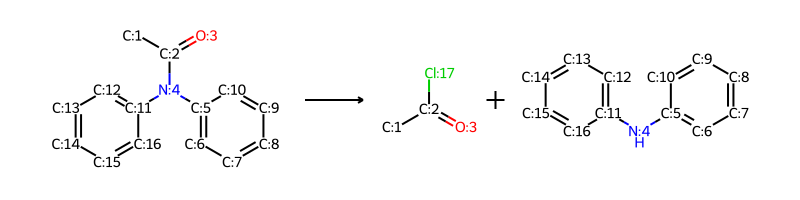

In [13]:
# Display rxn using rdkit
from rdkit.Chem import rdChemReactions
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.drawOptions.addAtomIndices = False
IPythonConsole.molSize = (600,200)
rxn = rdChemReactions.ReactionFromSmarts(rxn_smiles, useSmiles=True)
rdChemReactions.SanitizeRxn(rxn)
rxn

In [14]:
# When there is more than one reaction in the sequence, it's a bit more complicated to use jq for indexing
# As there are nested reactions
# Look at sequence 4 with 2 reactions
!jq '.[4]' trees.json

{
  "type": "mol",
  "hide": false,
  "smiles": "CC(=O)N(c1ccccc1)c1ccccc1",
  "is_chemical": true,
  "in_stock": false,
  "children": [
    {
      "type": "reaction",
      "hide": false,
      "smiles": "[c:1]([cH2:2])[cH2:3]>>Cl[c:1]([cH2:2])[cH2:3]",
      "is_reaction": true,
      "metadata": {
        "template_hash": "f8ab07b80fce95487c13336e9bb3bb463b96fafb3f4321187a2217687b0d0fb4",
        "classification": "0.0 Unrecognized",
        "library_occurence": 380,
        "policy_probability": 0.0012000000569969416,
        "policy_probability_rank": 14,
        "policy_name": "uspto",
        "template_code": 41345,
        "template": "[c:2]:[cH;D2;+0:1]:[c:3]>>Cl-[c;H0;D3;+0:1](:[c:2]):[c:3]",
        "mapped_reaction_smiles": "[CH3:1][C:2](=[O:3])[N:4]([c:5]1[cH:6][cH:7][cH:8][cH:9][cH:10]1)[c:11]1[cH:12][cH:13][cH:14][cH:15][cH:16]1>>[CH3:1][C:2](=[O:3])[N:4]([c:5]1[cH:6][cH:7][cH:8][cH:9][c:10]1[Cl:17])[c:11]1[cH:12][cH:13][cH:14][cH:15][cH:16]1"
      },
      "children":

In [15]:
# Here is a solution from ChatGPT4, very cool that jq can do this!
!jq '.[4].children[] | recurse(.children[]?) | select(.type == "reaction") | .metadata.mapped_reaction_smiles' trees.json

"[CH3:1][C:2](=[O:3])[N:4]([c:5]1[cH:6][cH:7][cH:8][cH:9][cH:10]1)[c:11]1[cH:12][cH:13][cH:14][cH:15][cH:16]1>>[CH3:1][C:2](=[O:3])[N:4]([c:5]1[cH:6][cH:7][cH:8][cH:9][c:10]1[Cl:17])[c:11]1[cH:12][cH:13][cH:14][cH:15][cH:16]1"
"[CH3:1][C:2](=[O:3])[N:4]([c:5]1[cH:6][cH:7][cH:8][cH:9][c:10]1[Cl:17])[c:11]1[cH:12][cH:13][cH:14][cH:15][cH:16]1>>[CH3:1][C:2](=[O:3])[NH:4][c:11]1[cH:12][cH:13][cH:14][cH:15][cH:16]1.[c:5]1([Br:18])[cH:6][cH:7][cH:8][cH:9][c:10]1[Cl:17]"


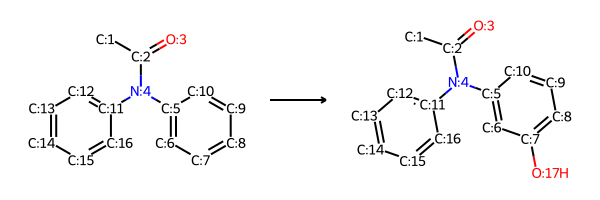

In [16]:
# depict rxns
rxn_smiles1 = "[CH3:1][C:2](=[O:3])[N:4]([c:5]1[cH:6][cH:7][cH:8][cH:9][cH:10]1)[c:11]1[cH:12][cH:13][cH:14][cH:15][cH:16]1\
    >>[CH3:1][C:2](=[O:3])[N:4]([c:5]1[cH:6][c:7]([OH:17])[cH:8][cH:9][cH:10]1)[c:11]1[cH:12][cH:13][cH:14][cH:15][cH:16]1"
rxn1 = rdChemReactions.ReactionFromSmarts(rxn_smiles1, useSmiles=True)
rdChemReactions.SanitizeRxn(rxn1)
rxn1

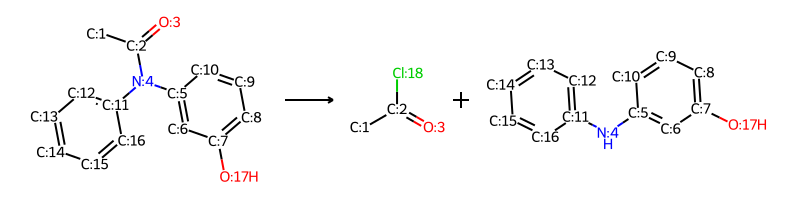

In [17]:
rxn_smiles2 = "[CH3:1][C:2](=[O:3])[N:4]([c:5]1[cH:6][c:7]([OH:17])[cH:8][cH:9][cH:10]1)[c:11]1[cH:12][cH:13][cH:14][cH:15][cH:16]1\
    >>[CH3:1][C:2](=[O:3])[Cl:18].[NH:4]([c:5]1[cH:6][c:7]([OH:17])[cH:8][cH:9][cH:10]1)[c:11]1[cH:12][cH:13][cH:14][cH:15][cH:16]1"
rxn2 = rdChemReactions.ReactionFromSmarts(rxn_smiles2, useSmiles=True)
rdChemReactions.SanitizeRxn(rxn1)
rxn2

## Python Interface

In [18]:
# Adapted from AiZynthFinder docs: https://molecularai.github.io/aizynthfinder/python_interface.html#
from aizynthfinder.aizynthfinder import AiZynthFinder
finder = AiZynthFinder(configfile="config.yml")

# Select policies
finder.stock.select("zinc")
finder.expansion_policy.select("uspto")
finder.filter_policy.select("uspto")

In [ ]:
# Get help on aizynthfinder main module
help(finder)

In [19]:
# Set the target molecule
finder.target_smiles = "CC(=O)N(C1=CC=CC=C1)C2=CC=CC=C2"

# Perfrom the retro tree search
finder.tree_search()

# Build the routes
finder.build_routes()

In [20]:
# Get tree statistics
stats = finder.extract_statistics()
stats

{'target': 'CC(=O)N(c1ccccc1)c1ccccc1',
 'search_time': 4.653566122055054,
 'first_solution_time': 0.4176919460296631,
 'first_solution_iteration': 1,
 'number_of_nodes': 182,
 'max_transforms': 3,
 'max_children': 42,
 'number_of_routes': 125,
 'number_of_solved_routes': 118,
 'top_score': 0.9976287063411217,
 'is_solved': True,
 'number_of_steps': 1,
 'number_of_precursors': 2,
 'number_of_precursors_in_stock': 2,
 'precursors_in_stock': 'CC(=O)Cl, c1ccc(Nc2ccccc2)cc1',
 'precursors_not_in_stock': '',
 'precursors_availability': 'zinc;zinc',
 'policy_used_counts': {'uspto': 181},
 'profiling': {'expansion_calls': 57,
  'reactants_generations': 151,
  'iterations': 100}}

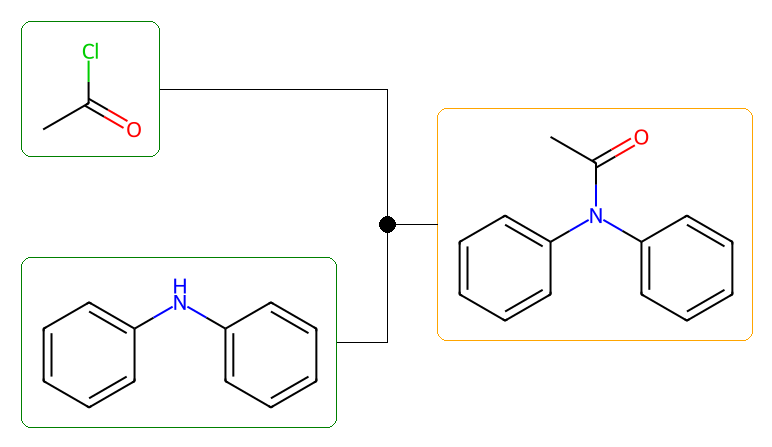

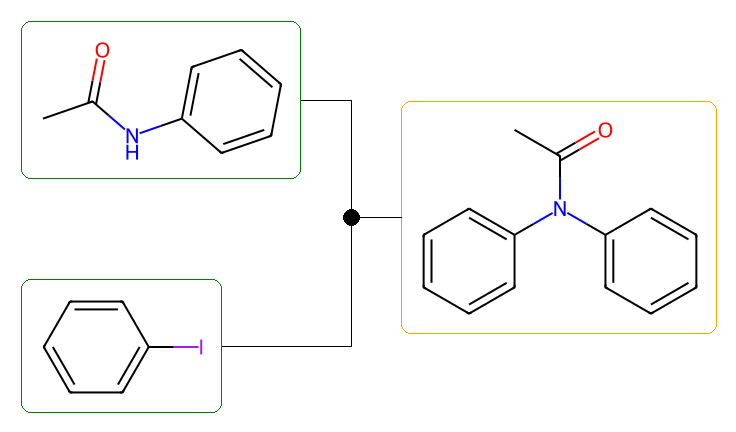

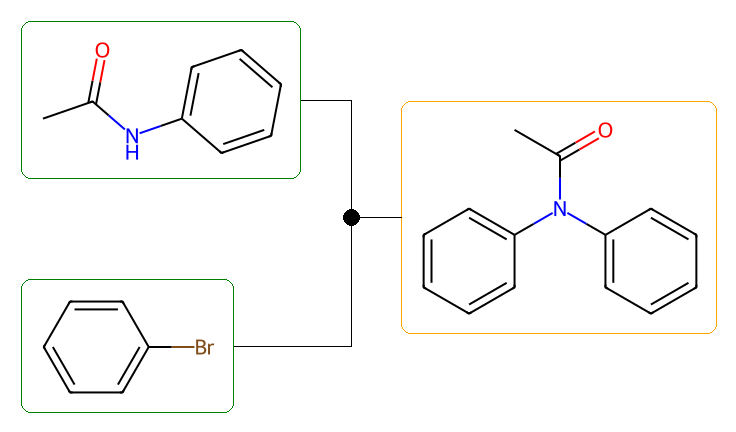

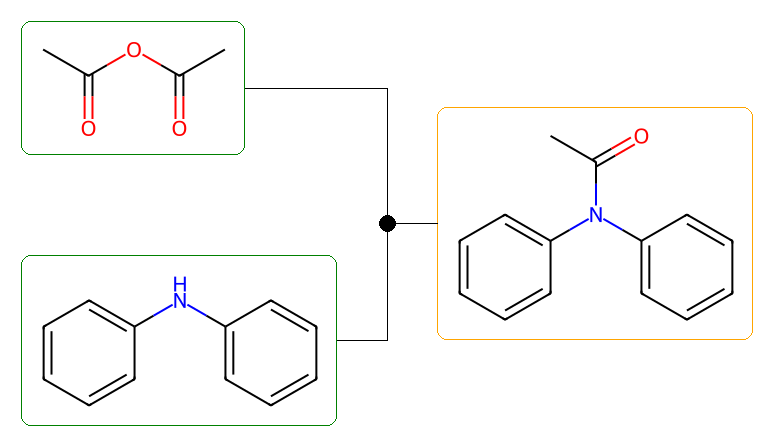

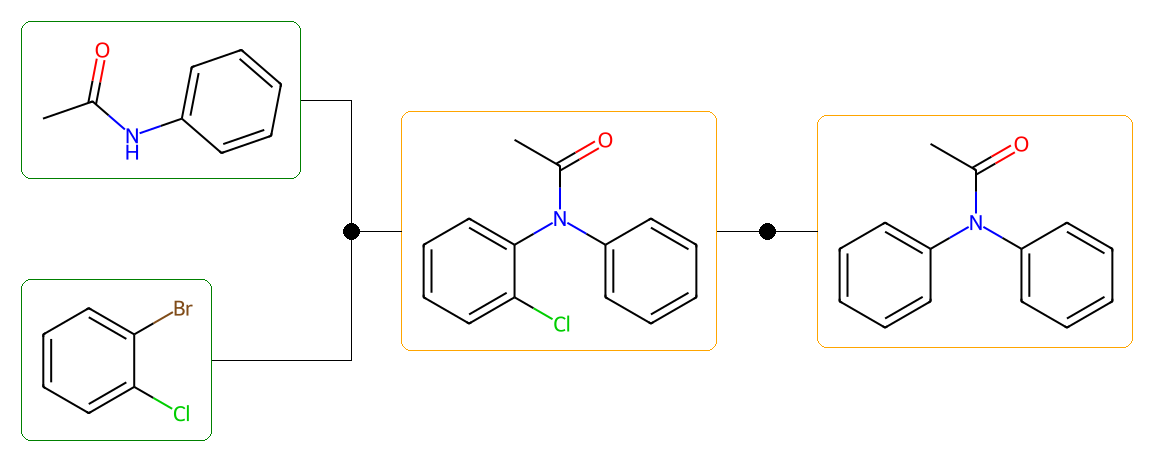

In [21]:
# Collect images of sequences
# display first 5
images = finder.routes.images
from IPython.display import display
for image in images[0:5]:
  display(image)

In [ ]:
# The analysis module can be used to collect the reaction routes and associated data
# https://molecularai.github.io/aizynthfinder/aizynthfinder.analysis.html

help(finder.routes)

In [22]:
# Get length of sequences
len(finder.routes.reaction_trees)

23

In [23]:
# Get scores of sequences
finder.routes.all_scores

[{'state score': 0.9976287063411217},
 {'state score': 0.9976287063411217},
 {'state score': 0.9976287063411217},
 {'state score': 0.9976287063411217},
 {'state score': 0.994039853898894},
 {'state score': 0.994039853898894},
 {'state score': 0.994039853898894},
 {'state score': 0.994039853898894},
 {'state score': 0.994039853898894},
 {'state score': 0.994039853898894},
 {'state score': 0.994039853898894},
 {'state score': 0.994039853898894},
 {'state score': 0.994039853898894},
 {'state score': 0.994039853898894},
 {'state score': 0.994039853898894},
 {'state score': 0.994039853898894},
 {'state score': 0.994039853898894},
 {'state score': 0.994039853898894},
 {'state score': 0.994039853898894},
 {'state score': 0.994039853898894},
 {'state score': 0.994039853898894},
 {'state score': 0.994039853898894},
 {'state score': 0.994039853898894}]

In [24]:
# Get the first reaction sequence
seq0 = finder.routes.reaction_trees[0]
seq0

In [25]:
# Print the associated data as a dictionary
seq0.to_dict(include_metadata=True)

{'route_metadata': {'created_at_iteration': 1, 'is_solved': True},
 'type': 'mol',
 'hide': False,
 'smiles': 'CC(=O)N(c1ccccc1)c1ccccc1',
 'is_chemical': True,
 'in_stock': False,
 'children': [{'type': 'reaction',
   'hide': False,
   'smiles': '[C:1]([CH3:2])(=[O:3])[N:5]([cH3:4])[cH3:6]>>Cl[C:1]([CH3:2])=[O:3].[cH3:4][N:5][cH3:6]',
   'is_reaction': True,
   'metadata': {'template_hash': '6a85e4224d5d8a27403ece099fa96a244aa27cf2c8971b4ca5ed98f9ffdaea4b',
    'classification': '0.0 Unrecognized',
    'library_occurence': 82,
    'policy_probability': 0.3776000142097473,
    'policy_probability_rank': 0,
    'policy_name': 'uspto',
    'template_code': 17758,
    'template': '[C;D1;H3:2]-[C;H0;D3;+0:1](=[O;D1;H0:3])-[N;H0;D3;+0:5](-[c:4])-[c:6]>>Cl-[C;H0;D3;+0:1](-[C;D1;H3:2])=[O;D1;H0:3].[c:4]-[NH;D2;+0:5]-[c:6]',
    'mapped_reaction_smiles': '[CH3:1][C:2](=[O:3])[N:4]([c:5]1[cH:6][cH:7][cH:8][cH:9][cH:10]1)[c:11]1[cH:12][cH:13][cH:14][cH:15][cH:16]1>>[CH3:1][C:2](=[O:3])[Cl:17].[N

In [26]:
# another example, seq4
finder.routes.reaction_trees[4].to_dict()

{'type': 'mol',
 'hide': False,
 'smiles': 'CC(=O)N(c1ccccc1)c1ccccc1',
 'is_chemical': True,
 'in_stock': False,
 'children': [{'type': 'reaction',
   'hide': False,
   'smiles': '[c:1]([cH2:2])[cH2:3]>>Cl[c:1]([cH2:2])[cH2:3]',
   'is_reaction': True,
   'metadata': {'template_hash': 'f8ab07b80fce95487c13336e9bb3bb463b96fafb3f4321187a2217687b0d0fb4',
    'classification': '0.0 Unrecognized',
    'library_occurence': 380,
    'policy_probability': 0.0012000000569969416,
    'policy_probability_rank': 14,
    'policy_name': 'uspto',
    'template_code': 41345,
    'template': '[c:2]:[cH;D2;+0:1]:[c:3]>>Cl-[c;H0;D3;+0:1](:[c:2]):[c:3]',
    'mapped_reaction_smiles': '[CH3:1][C:2](=[O:3])[N:4]([c:5]1[cH:6][cH:7][cH:8][cH:9][cH:10]1)[c:11]1[cH:12][cH:13][cH:14][cH:15][cH:16]1>>[CH3:1][C:2](=[O:3])[N:4]([c:5]1[cH:6][cH:7][cH:8][cH:9][cH:10]1)[c:11]1[cH:12][cH:13][cH:14][cH:15][c:16]1[Cl:17]'},
   'children': [{'type': 'mol',
     'hide': False,
     'smiles': 'CC(=O)N(c1ccccc1)c1ccccc1Cl',

In [ ]:
# We want to be able to extract out some information for all rxn sequences into
# a dictionary so that we can, for example, use the rxn template data and
# plot rxns later

# We will extract out the target smiles, rxns, templates, and stock status.
# We originally extracted the sequence data from this type of dictionary output shown above,
# however, this proved to be compilcated as it is recursive exercise when there is
# more than one reaction per sequence (see self-study code at the end of this notebook).

# Our sincere thanks to Samuel Genheden (AstraZeneca) for providing us starter code
# which uses the internal AiZynthFinder object instead, avoiding recursion.

# Here is a look at the reaction tree object properties and methods to get associated data
help(seq0)

In [27]:
# Get target SMILES and stock status
print(seq0.root.smiles)
print(seq0.in_stock(seq0.root))

CC(=O)N(c1ccccc1)c1ccccc1
False


In [28]:
# Get reactions and associated data for the sequence
reactions = seq0.reactions()
for reaction in reactions:
    print(reaction.metadata)
    print(reaction.metadata["library_occurence"])
    print(reaction.metadata["mapped_reaction_smiles"])
    #print(help(reaction))

{'template_hash': '6a85e4224d5d8a27403ece099fa96a244aa27cf2c8971b4ca5ed98f9ffdaea4b', 'classification': '0.0 Unrecognized', 'library_occurence': 82, 'policy_probability': 0.3776000142097473, 'policy_probability_rank': 0, 'policy_name': 'uspto', 'template_code': 17758, 'template': '[C;D1;H3:2]-[C;H0;D3;+0:1](=[O;D1;H0:3])-[N;H0;D3;+0:5](-[c:4])-[c:6]>>Cl-[C;H0;D3;+0:1](-[C;D1;H3:2])=[O;D1;H0:3].[c:4]-[NH;D2;+0:5]-[c:6]', 'mapped_reaction_smiles': '[CH3:1][C:2](=[O:3])[N:4]([c:5]1[cH:6][cH:7][cH:8][cH:9][cH:10]1)[c:11]1[cH:12][cH:13][cH:14][cH:15][cH:16]1>>[CH3:1][C:2](=[O:3])[Cl:17].[NH:4]([c:5]1[cH:6][cH:7][cH:8][cH:9][cH:10]1)[c:11]1[cH:12][cH:13][cH:14][cH:15][cH:16]1'}
82
[CH3:1][C:2](=[O:3])[N:4]([c:5]1[cH:6][cH:7][cH:8][cH:9][cH:10]1)[c:11]1[cH:12][cH:13][cH:14][cH:15][cH:16]1>>[CH3:1][C:2](=[O:3])[Cl:17].[NH:4]([c:5]1[cH:6][cH:7][cH:8][cH:9][cH:10]1)[c:11]1[cH:12][cH:13][cH:14][cH:15][cH:16]1


In [29]:
# Get reactants and data from the reactions
reactions = seq0.reactions()
for reaction in reactions:
    for reactant in reaction.reactants[0]:
        print(reactant.smiles)
        print(seq0.in_stock(reactant))
        #print(help(reactant))

CC(=O)Cl
True
c1ccc(Nc2ccccc2)cc1
True


In [30]:
# Now we can put this all together to extract out some key data
# Again, thanks to Samuel Genheden for providing this code!

seq0 = finder.routes.reaction_trees[0]
scores = finder.routes.all_scores[0]
dict_ = {
    "target_smiles": seq0.root.smiles,
    "in_stock": seq0.in_stock(seq0.root),
    "state_score": scores["state score"],
    "list_of_reactions": [],
 
}
for reaction in seq0.reactions():
    rxn_dict = {
        "rxn_target_smiles": reaction.mol.smiles,
        "library_occurence": reaction.metadata["library_occurence"],
        "template": reaction.metadata["template"],
        "mapped_reaction_smiles": reaction.metadata["mapped_reaction_smiles"],
        "mol_children": [
            {"smiles": reactant.smiles, "in_stock": seq0.in_stock(reactant)}
            for reactant in reaction.reactants[0]
        ]
    }
    dict_["list_of_reactions"].append(rxn_dict)
dict_

{'target_smiles': 'CC(=O)N(c1ccccc1)c1ccccc1',
 'in_stock': False,
 'state_score': 0.9976287063411217,
 'list_of_reactions': [{'rxn_target_smiles': 'CC(=O)N(c1ccccc1)c1ccccc1',
   'library_occurence': 82,
   'template': '[C;D1;H3:2]-[C;H0;D3;+0:1](=[O;D1;H0:3])-[N;H0;D3;+0:5](-[c:4])-[c:6]>>Cl-[C;H0;D3;+0:1](-[C;D1;H3:2])=[O;D1;H0:3].[c:4]-[NH;D2;+0:5]-[c:6]',
   'mapped_reaction_smiles': '[CH3:1][C:2](=[O:3])[N:4]([c:5]1[cH:6][cH:7][cH:8][cH:9][cH:10]1)[c:11]1[cH:12][cH:13][cH:14][cH:15][cH:16]1>>[CH3:1][C:2](=[O:3])[Cl:17].[NH:4]([c:5]1[cH:6][cH:7][cH:8][cH:9][cH:10]1)[c:11]1[cH:12][cH:13][cH:14][cH:15][cH:16]1',
   'mol_children': [{'smiles': 'CC(=O)Cl', 'in_stock': True},
    {'smiles': 'c1ccc(Nc2ccccc2)cc1', 'in_stock': True}]}]}

In [ ]:
# now we can loop through all sequences (22) and extract out the data

all_sequences_data = {}
# Loop through all reaction trees (sequences)
for seq_idx, seq in enumerate(finder.routes.reaction_trees):
    # Get score for the current sequence
    scores = finder.routes.all_scores[seq_idx]
    
    # Create a dictionary to hold the data for the current sequence
    seq_data = {
        "target_smiles": seq.root.smiles,
        "in_stock": seq.in_stock(seq.root),
        "state_score": scores["state score"],
        "list_of_reactions": [],
    }
    
    # Loop through all reactions in the current sequence
    for reaction in seq.reactions():
        # Create a dictionary to hold data for each reaction
        rxn_data = {
            "rxn_target_smiles": reaction.mol.smiles,
            "library_occurence": reaction.metadata["library_occurence"],
            "template": reaction.metadata["template"],
            "mapped_reaction_smiles": reaction.metadata["mapped_reaction_smiles"],
            "mol_children": [
                {"smiles": reactant.smiles, "in_stock": seq.in_stock(reactant)}
                for reactant in reaction.reactants[0]
            ]
        }
        # Add the reaction data to the sequence dictionary
        seq_data["list_of_reactions"].append(rxn_data)
    
    # Append the sequence data to the list of all sequences
    all_sequences_data[f'seq{seq_idx}'] = seq_data

all_sequences_data

In [32]:
# Okay, let's try another example from start to finish
# Set the target molecule
# CID: 46861578
finder.target_smiles = "C1=CC(=CC=C1N(C2=CC=C(C=C2)F)C(=O)C3=CC(=C(C=C3)O)F)O"

# Perfrom the retro tree search
finder.tree_search()

# Build the routes
finder.build_routes()

In [33]:
# collect the sequences
sequences = finder.routes.reaction_trees

In [34]:
# get number of sequences
len(sequences)

7

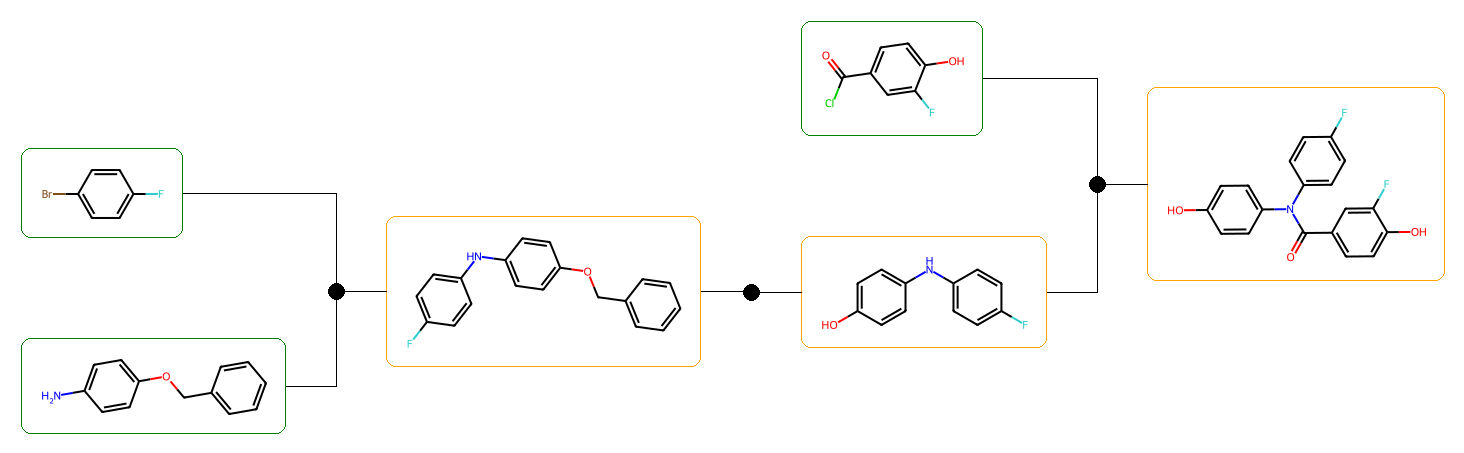

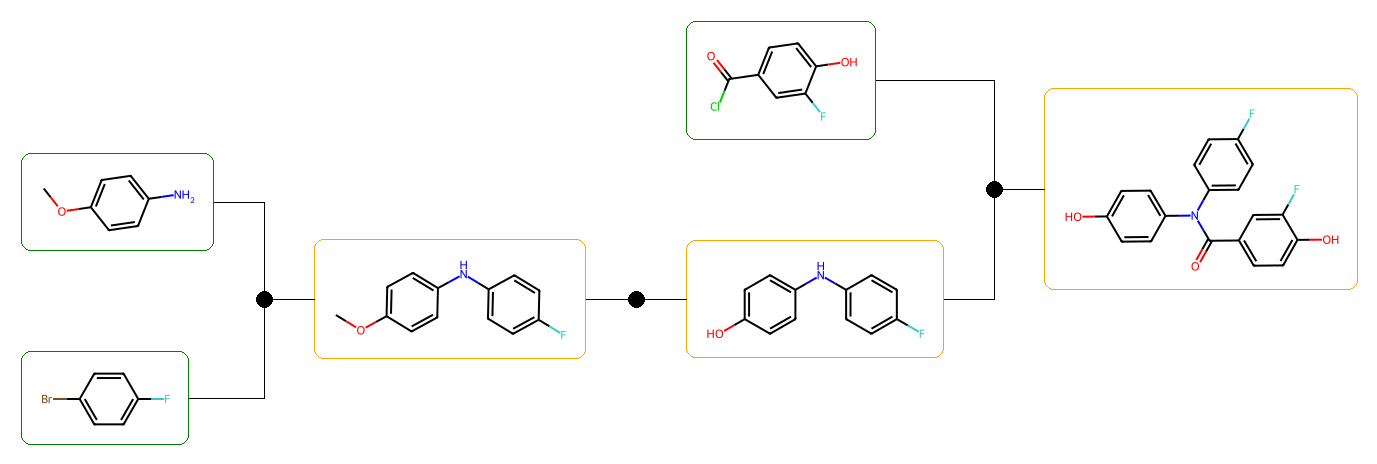

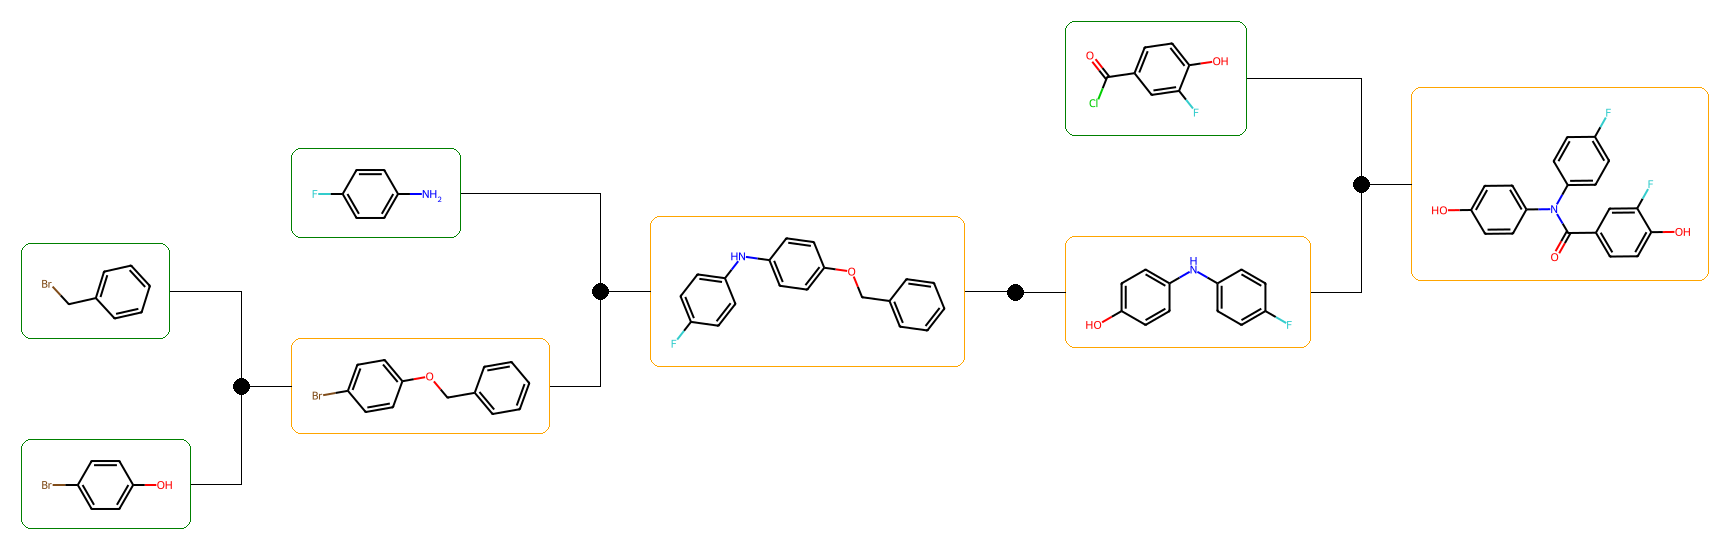

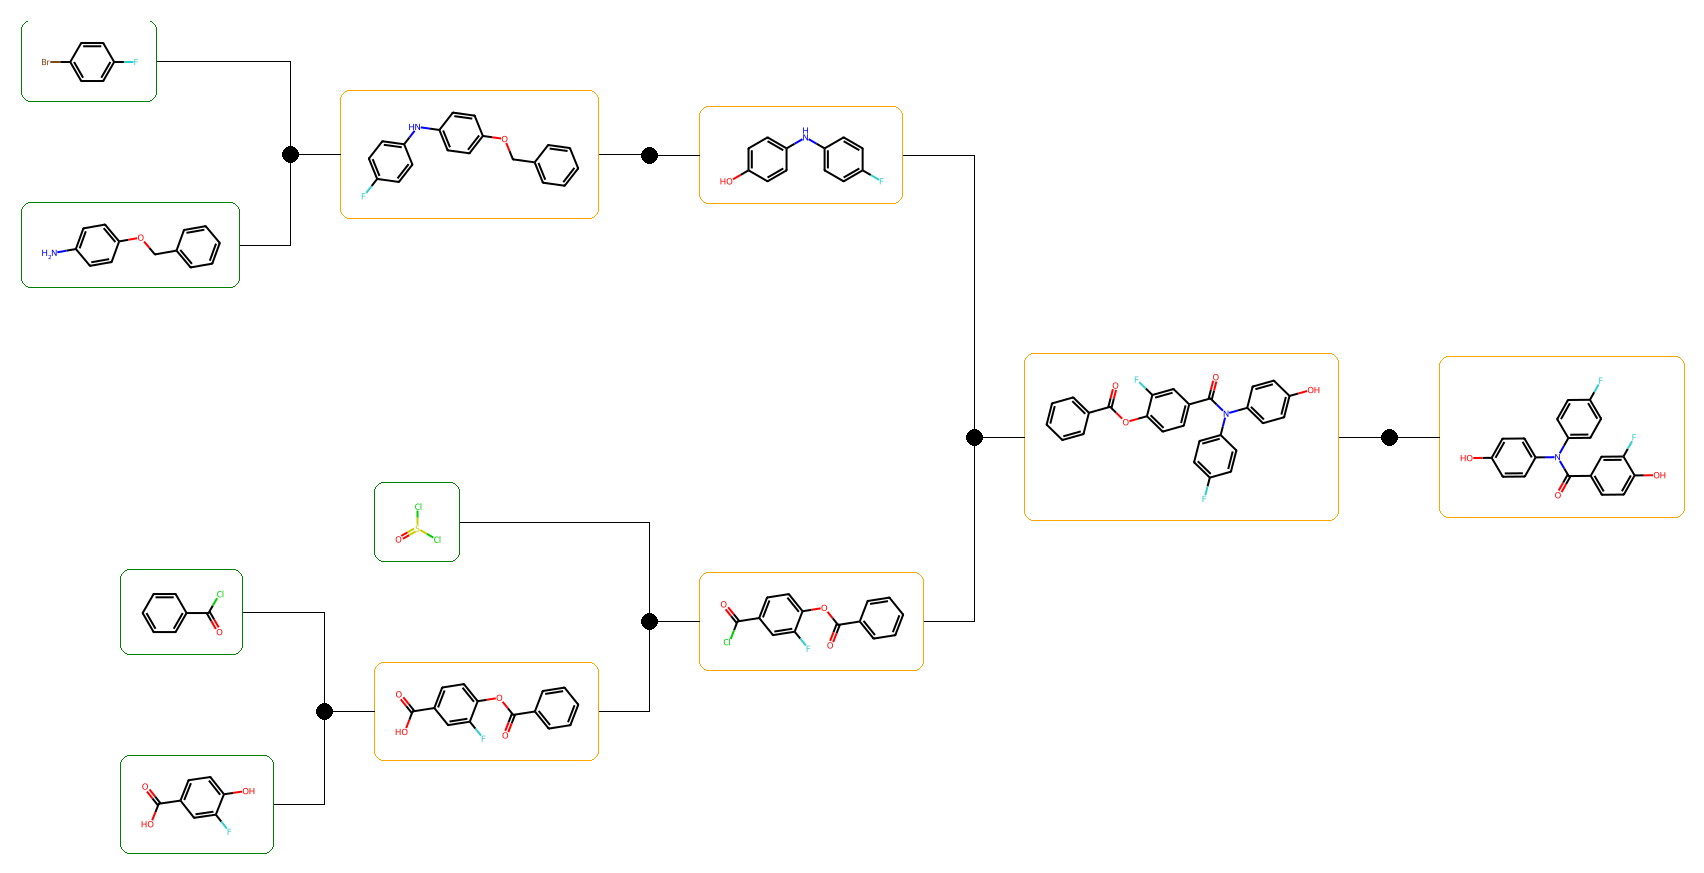

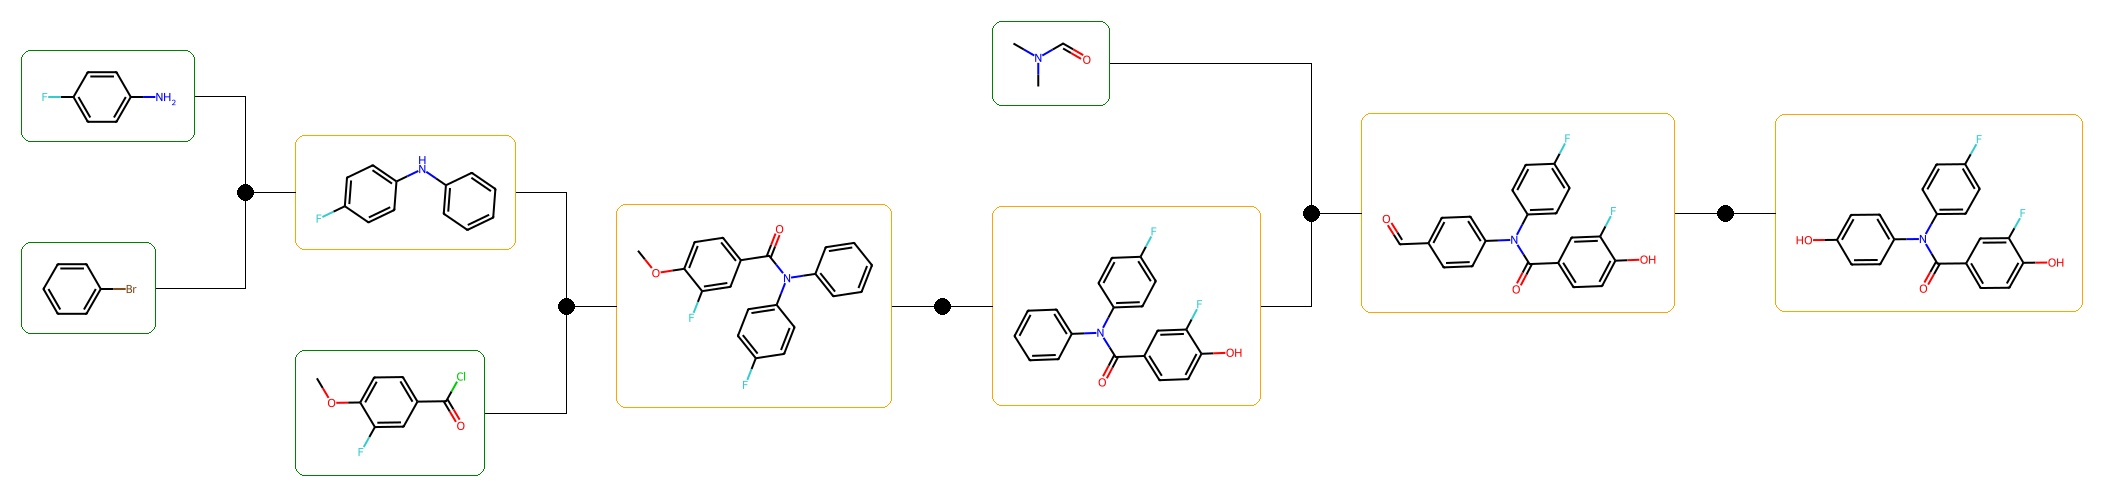

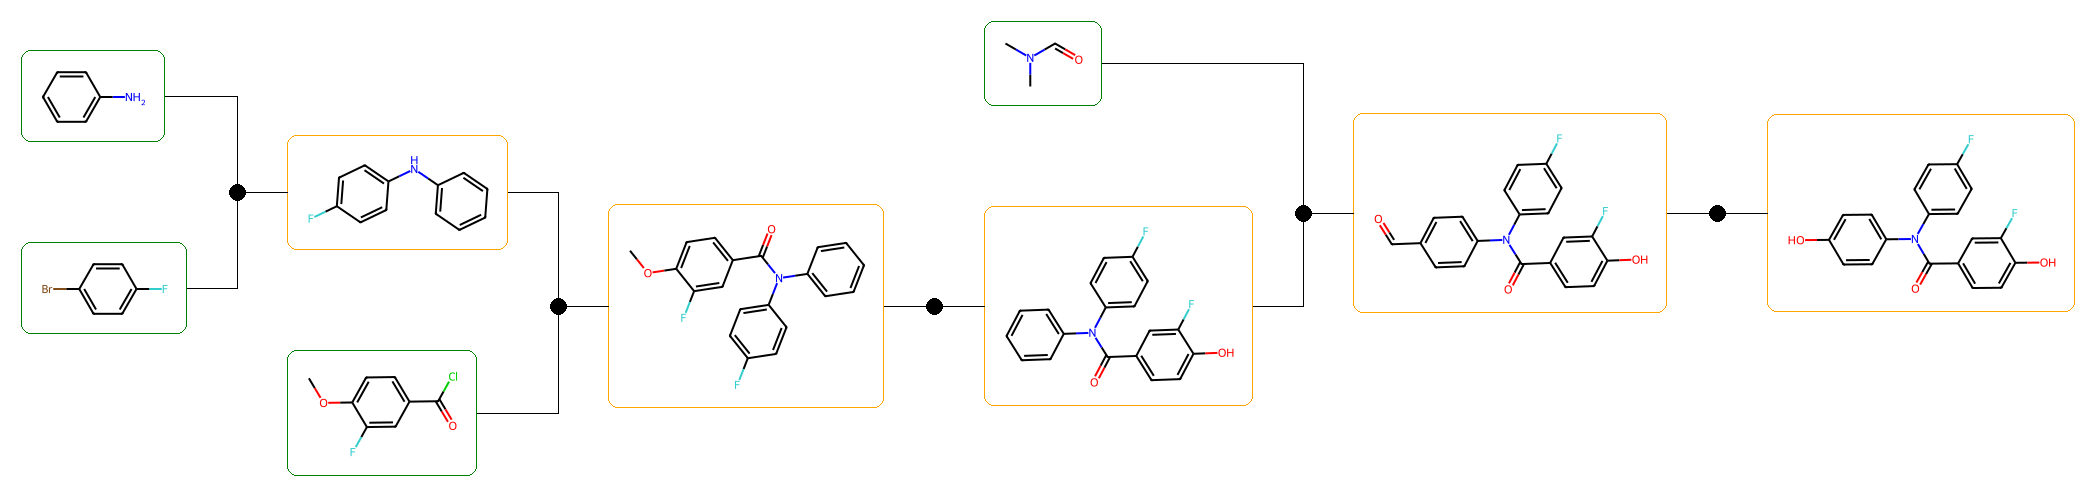

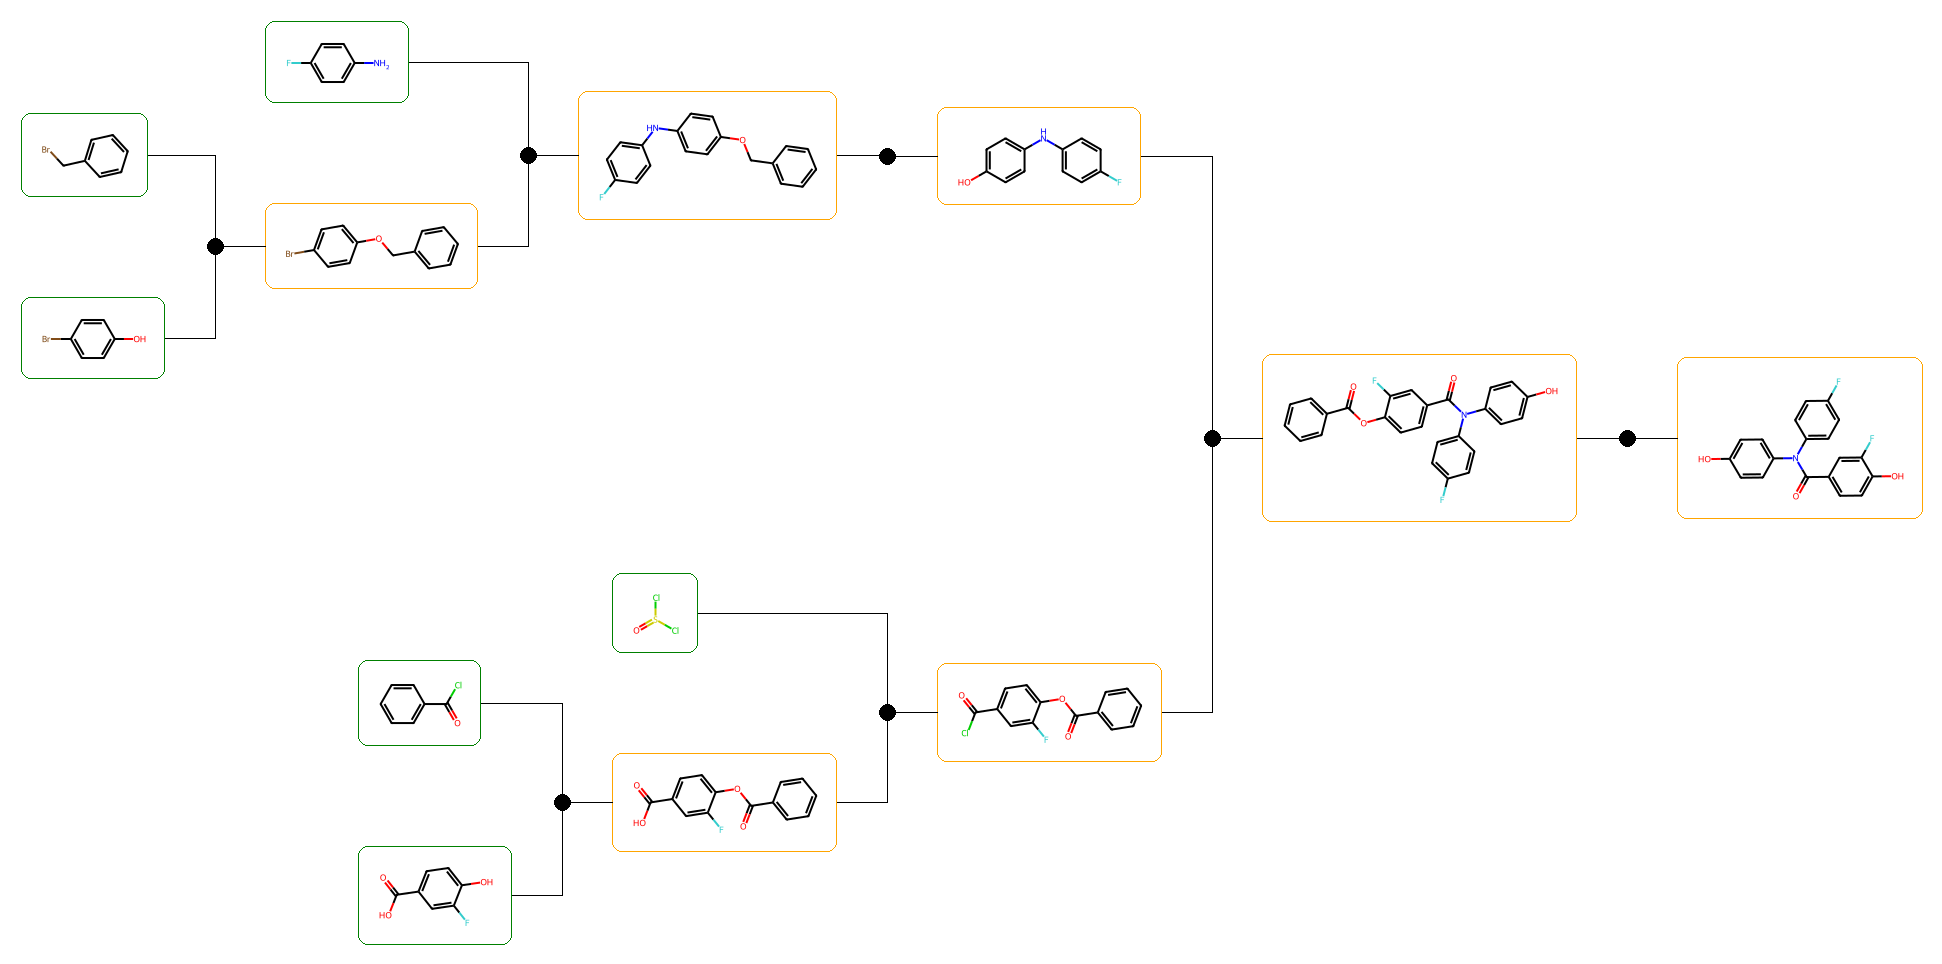

In [35]:
# Collect images of sequences
images = finder.routes.images
from IPython.display import display
for image in images:
  display(image)

In [36]:
# Now let's compile data as before
all_sequences_data2 = {}
# Loop through all reaction trees (sequences)
for seq_idx, seq in enumerate(sequences):
    # Get score for the current sequence
    scores = finder.routes.all_scores[seq_idx]
    
    # Create a dictionary to hold the data for the current sequence
    seq_data = {
        "target_smiles": seq.root.smiles,
        "in_stock": seq.in_stock(seq.root),
        "state_score": scores["state score"],
        "list_of_reactions": [],
    }
    
    # Loop through all reactions in the current sequence
    for reaction in seq.reactions():
        # Create a dictionary to hold data for each reaction
        rxn_data = {
            "rxn_target_smiles": reaction.mol.smiles,
            "library_occurence": reaction.metadata["library_occurence"],
            "template": reaction.metadata["template"],
            "mapped_reaction_smiles": reaction.metadata["mapped_reaction_smiles"],
            "mol_children": [
                {"smiles": reactant.smiles, "in_stock": seq.in_stock(reactant)}
                for reactant in reaction.reactants[0]
            ]
        }
        # Add the reaction data to the sequence dictionary
        seq_data["list_of_reactions"].append(rxn_data)
    
    # Append the sequence data to the list of all sequences
    all_sequences_data2[f'seq{seq_idx}'] = seq_data

all_sequences_data2

{'seq0': {'target_smiles': 'O=C(c1ccc(O)c(F)c1)N(c1ccc(O)cc1)c1ccc(F)cc1',
  'in_stock': False,
  'state_score': 0.9865529289315002,
  'list_of_reactions': [{'rxn_target_smiles': 'O=C(c1ccc(O)c(F)c1)N(c1ccc(O)cc1)c1ccc(F)cc1',
    'library_occurence': 16,
    'template': '[O;D1;H0:2]=[C;H0;D3;+0:1](-[c:3])-[N;H0;D3;+0:5](-[c:4])-[c:6]>>Cl-[C;H0;D3;+0:1](=[O;D1;H0:2])-[c:3].[c:4]-[NH;D2;+0:5]-[c:6]',
    'mapped_reaction_smiles': '[O:1]=[C:2]([c:3]1[cH:4][cH:5][c:6]([OH:7])[c:8]([F:9])[cH:10]1)[N:11]([c:12]1[cH:13][cH:14][c:15]([OH:16])[cH:17][cH:18]1)[c:19]1[cH:20][cH:21][c:22]([F:23])[cH:24][cH:25]1>>[NH:11]([c:12]1[cH:13][cH:14][c:15]([OH:16])[cH:17][cH:18]1)[c:19]1[cH:20][cH:21][c:22]([F:23])[cH:24][cH:25]1.[O:1]=[C:2]([c:3]1[cH:4][cH:5][c:6]([OH:7])[c:8]([F:9])[cH:10]1)[Cl:26]',
    'mol_children': [{'smiles': 'Oc1ccc(Nc2ccc(F)cc2)cc1', 'in_stock': False},
     {'smiles': 'O=C(Cl)c1ccc(O)c(F)c1', 'in_stock': True}]},
   {'rxn_target_smiles': 'Oc1ccc(Nc2ccc(F)cc2)cc1',
    'library_

In [37]:
# we can loop through the data like this
for key,value in all_sequences_data2.items():
    print(value)

{'target_smiles': 'O=C(c1ccc(O)c(F)c1)N(c1ccc(O)cc1)c1ccc(F)cc1', 'in_stock': False, 'state_score': 0.9865529289315002, 'list_of_reactions': [{'rxn_target_smiles': 'O=C(c1ccc(O)c(F)c1)N(c1ccc(O)cc1)c1ccc(F)cc1', 'library_occurence': 16, 'template': '[O;D1;H0:2]=[C;H0;D3;+0:1](-[c:3])-[N;H0;D3;+0:5](-[c:4])-[c:6]>>Cl-[C;H0;D3;+0:1](=[O;D1;H0:2])-[c:3].[c:4]-[NH;D2;+0:5]-[c:6]', 'mapped_reaction_smiles': '[O:1]=[C:2]([c:3]1[cH:4][cH:5][c:6]([OH:7])[c:8]([F:9])[cH:10]1)[N:11]([c:12]1[cH:13][cH:14][c:15]([OH:16])[cH:17][cH:18]1)[c:19]1[cH:20][cH:21][c:22]([F:23])[cH:24][cH:25]1>>[NH:11]([c:12]1[cH:13][cH:14][c:15]([OH:16])[cH:17][cH:18]1)[c:19]1[cH:20][cH:21][c:22]([F:23])[cH:24][cH:25]1.[O:1]=[C:2]([c:3]1[cH:4][cH:5][c:6]([OH:7])[c:8]([F:9])[cH:10]1)[Cl:26]', 'mol_children': [{'smiles': 'Oc1ccc(Nc2ccc(F)cc2)cc1', 'in_stock': False}, {'smiles': 'O=C(Cl)c1ccc(O)c(F)c1', 'in_stock': True}]}, {'rxn_target_smiles': 'Oc1ccc(Nc2ccc(F)cc2)cc1', 'library_occurence': 333, 'template': '[#7:1]-[c:2]1

seq0
state_score 0.9865529289315002
Target smiles: O=C(c1ccc(O)c(F)c1)N(c1ccc(O)cc1)c1ccc(F)cc1, in_stock': False
 
seq0, reaction 3 data:

target smiles: O=C(c1ccc(O)c(F)c1)N(c1ccc(O)cc1)c1ccc(F)cc1
library_occurence: 16
template: [O;D1;H0:2]=[C;H0;D3;+0:1](-[c:3])-[N;H0;D3;+0:5](-[c:4])-[c:6]>>Cl-[C;H0;D3;+0:1](=[O;D1;H0:2])-[c:3].[c:4]-[NH;D2;+0:5]-[c:6]


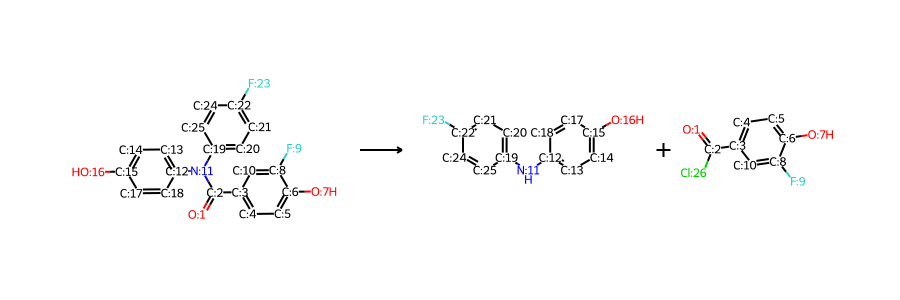

precursor mols: {'smiles': 'Oc1ccc(Nc2ccc(F)cc2)cc1', 'in_stock': False}
precursor mols: {'smiles': 'O=C(Cl)c1ccc(O)c(F)c1', 'in_stock': True}
 
 
seq0, reaction 2 data:

target smiles: Oc1ccc(Nc2ccc(F)cc2)cc1
library_occurence: 333
template: [#7:1]-[c:2]1:[c:3]:[c:4]:[c:5](-[OH;D1;+0:6]):[c:7]:[c:8]:1>>[#7:1]-[c:2]1:[c:3]:[c:4]:[c:5](-[O;H0;D2;+0:6]-C-c2:c:c:c:c:c:2):[c:7]:[c:8]:1


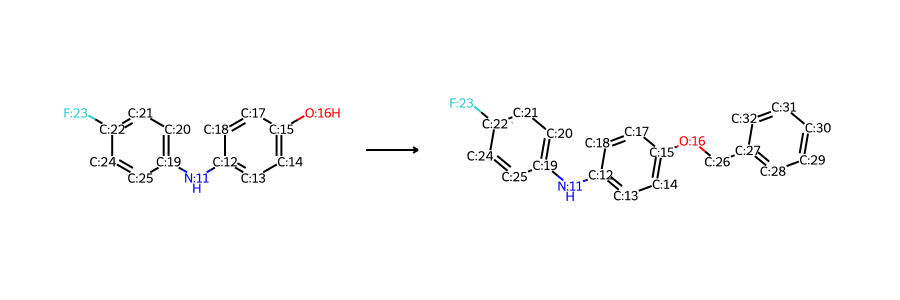

precursor mols: {'smiles': 'Fc1ccc(Nc2ccc(OCc3ccccc3)cc2)cc1', 'in_stock': False}
 
 
seq0, reaction 1 data:

target smiles: Fc1ccc(Nc2ccc(OCc3ccccc3)cc2)cc1
library_occurence: 772
template: [c:2]:[c;H0;D3;+0:1](:[c:3])-[NH;D2;+0:4]-[c:5]>>Br-[c;H0;D3;+0:1](:[c:2]):[c:3].[NH2;D1;+0:4]-[c:5]


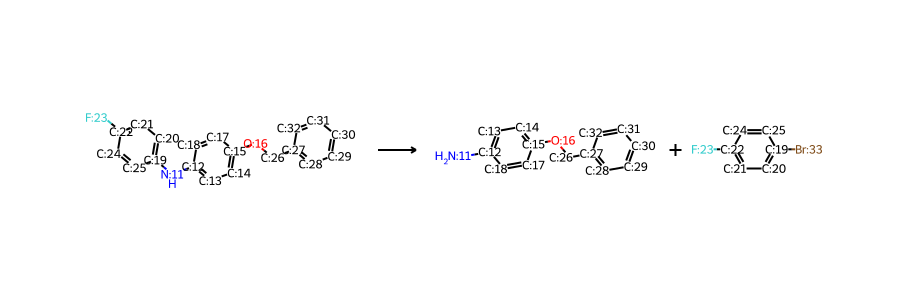

precursor mols: {'smiles': 'Nc1ccc(OCc2ccccc2)cc1', 'in_stock': True}
precursor mols: {'smiles': 'Fc1ccc(Br)cc1', 'in_stock': True}
 
 
--------------------------------------------



seq1
state_score 0.9865529289315002
Target smiles: O=C(c1ccc(O)c(F)c1)N(c1ccc(O)cc1)c1ccc(F)cc1, in_stock': False
 
seq1, reaction 3 data:

target smiles: O=C(c1ccc(O)c(F)c1)N(c1ccc(O)cc1)c1ccc(F)cc1
library_occurence: 16
template: [O;D1;H0:2]=[C;H0;D3;+0:1](-[c:3])-[N;H0;D3;+0:5](-[c:4])-[c:6]>>Cl-[C;H0;D3;+0:1](=[O;D1;H0:2])-[c:3].[c:4]-[NH;D2;+0:5]-[c:6]


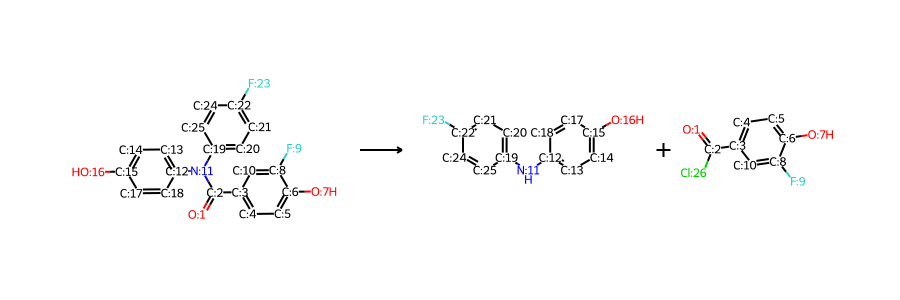

precursor mols: {'smiles': 'Oc1ccc(Nc2ccc(F)cc2)cc1', 'in_stock': False}
precursor mols: {'smiles': 'O=C(Cl)c1ccc(O)c(F)c1', 'in_stock': True}
 
 
seq1, reaction 2 data:

target smiles: Oc1ccc(Nc2ccc(F)cc2)cc1
library_occurence: 551
template: [#7:6]-[c:5]1:[c:4]:[c:3]:[c:2](-[OH;D1;+0:1]):[c:8]:[c:7]:1>>C-[O;H0;D2;+0:1]-[c:2]1:[c:3]:[c:4]:[c:5](-[#7:6]):[c:7]:[c:8]:1


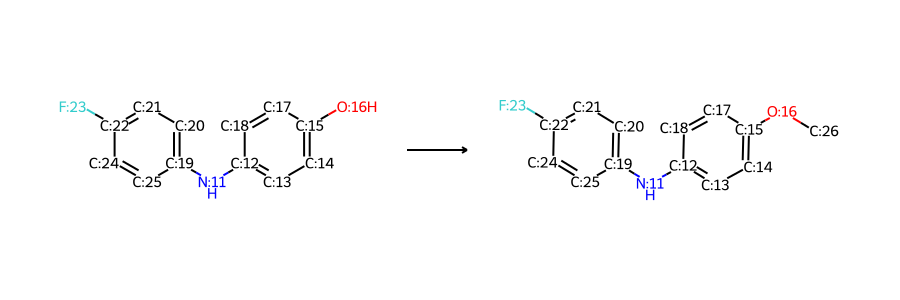

precursor mols: {'smiles': 'COc1ccc(Nc2ccc(F)cc2)cc1', 'in_stock': False}
 
 
seq1, reaction 1 data:

target smiles: COc1ccc(Nc2ccc(F)cc2)cc1
library_occurence: 80
template: [C;D1;H3:4]-[#8:5]-[c:6]1:[c:7]:[c:8]:[c:9](-[NH;D2;+0:10]-[c;H0;D3;+0:1](:[c:2]):[c:3]):[c:11]:[c:12]:1>>Br-[c;H0;D3;+0:1](:[c:2]):[c:3].[C;D1;H3:4]-[#8:5]-[c:6]1:[c:7]:[c:8]:[c:9](-[NH2;D1;+0:10]):[c:11]:[c:12]:1


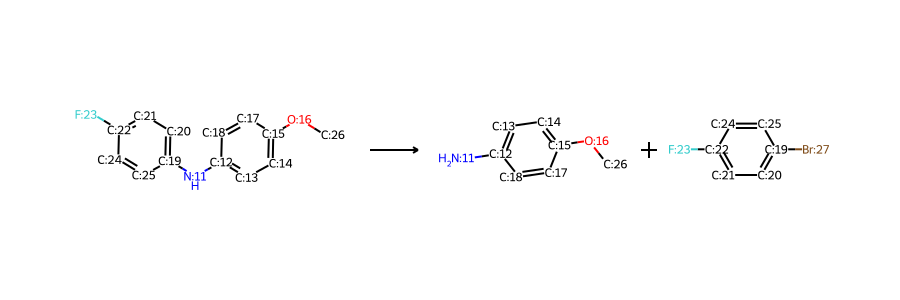

precursor mols: {'smiles': 'COc1ccc(N)cc1', 'in_stock': True}
precursor mols: {'smiles': 'Fc1ccc(Br)cc1', 'in_stock': True}
 
 
--------------------------------------------



seq2
state_score 0.975
Target smiles: O=C(c1ccc(O)c(F)c1)N(c1ccc(O)cc1)c1ccc(F)cc1, in_stock': False
 
seq2, reaction 4 data:

target smiles: O=C(c1ccc(O)c(F)c1)N(c1ccc(O)cc1)c1ccc(F)cc1
library_occurence: 16
template: [O;D1;H0:2]=[C;H0;D3;+0:1](-[c:3])-[N;H0;D3;+0:5](-[c:4])-[c:6]>>Cl-[C;H0;D3;+0:1](=[O;D1;H0:2])-[c:3].[c:4]-[NH;D2;+0:5]-[c:6]


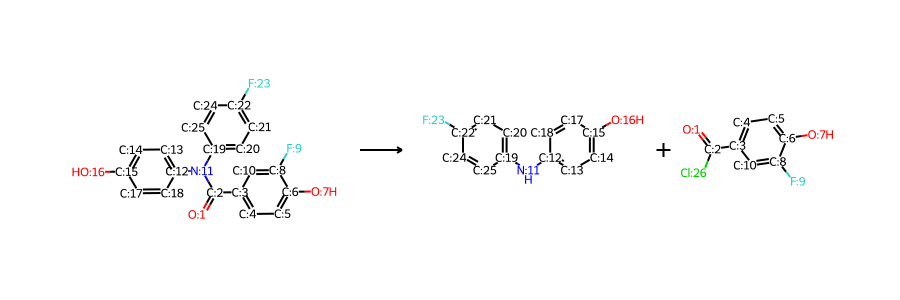

precursor mols: {'smiles': 'Oc1ccc(Nc2ccc(F)cc2)cc1', 'in_stock': False}
precursor mols: {'smiles': 'O=C(Cl)c1ccc(O)c(F)c1', 'in_stock': True}
 
 
seq2, reaction 3 data:

target smiles: Oc1ccc(Nc2ccc(F)cc2)cc1
library_occurence: 333
template: [#7:1]-[c:2]1:[c:3]:[c:4]:[c:5](-[OH;D1;+0:6]):[c:7]:[c:8]:1>>[#7:1]-[c:2]1:[c:3]:[c:4]:[c:5](-[O;H0;D2;+0:6]-C-c2:c:c:c:c:c:2):[c:7]:[c:8]:1


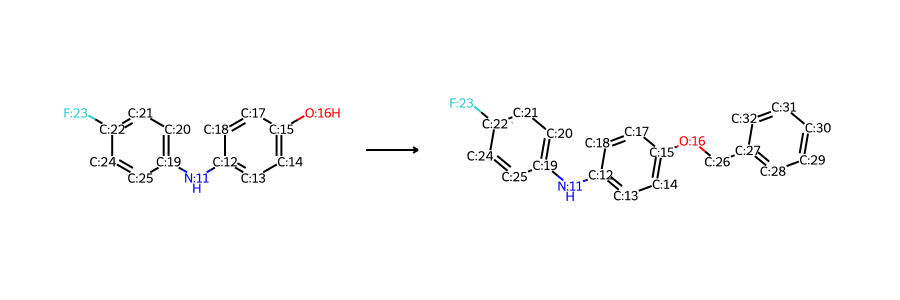

precursor mols: {'smiles': 'Fc1ccc(Nc2ccc(OCc3ccccc3)cc2)cc1', 'in_stock': False}
 
 
seq2, reaction 2 data:

target smiles: Fc1ccc(Nc2ccc(OCc3ccccc3)cc2)cc1
library_occurence: 772
template: [c:2]:[c;H0;D3;+0:1](:[c:3])-[NH;D2;+0:4]-[c:5]>>Br-[c;H0;D3;+0:1](:[c:2]):[c:3].[NH2;D1;+0:4]-[c:5]


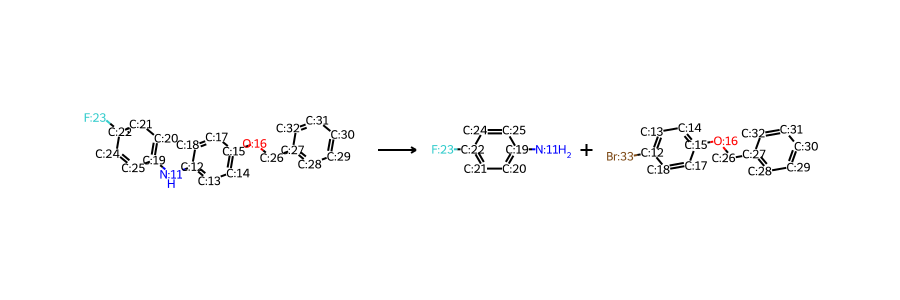

precursor mols: {'smiles': 'Nc1ccc(F)cc1', 'in_stock': True}
precursor mols: {'smiles': 'Brc1ccc(OCc2ccccc2)cc1', 'in_stock': False}
 
 
seq2, reaction 1 data:

target smiles: Brc1ccc(OCc2ccccc2)cc1
library_occurence: 5146
template: [c:4]-[O;H0;D2;+0:3]-[CH2;D2;+0:1]-[c:2]>>Br-[CH2;D2;+0:1]-[c:2].[OH;D1;+0:3]-[c:4]


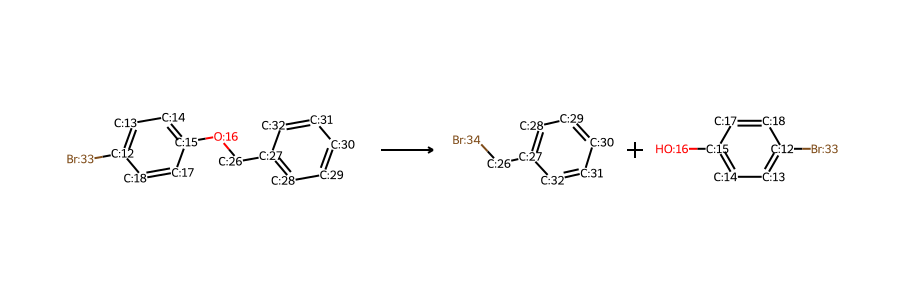

precursor mols: {'smiles': 'BrCc1ccccc1', 'in_stock': True}
precursor mols: {'smiles': 'Oc1ccc(Br)cc1', 'in_stock': True}
 
 
--------------------------------------------



seq3
state_score 0.975
Target smiles: O=C(c1ccc(O)c(F)c1)N(c1ccc(O)cc1)c1ccc(F)cc1, in_stock': False
 
seq3, reaction 6 data:

target smiles: O=C(c1ccc(O)c(F)c1)N(c1ccc(O)cc1)c1ccc(F)cc1
library_occurence: 111
template: [OH;D1;+0:1]-[c:2]>>O=C(-[O;H0;D2;+0:1]-[c:2])-c1:c:c:c:c:c:1


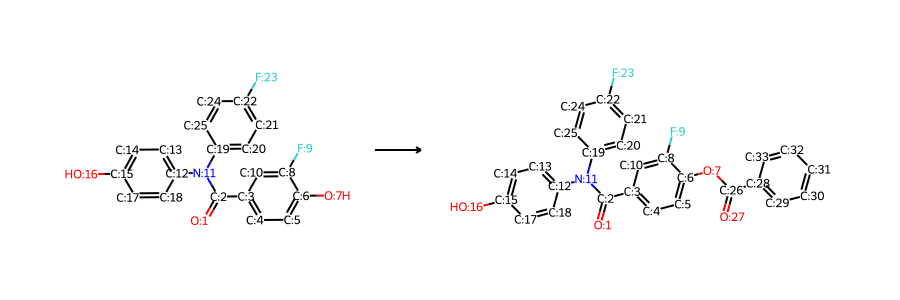

precursor mols: {'smiles': 'O=C(Oc1ccc(C(=O)N(c2ccc(O)cc2)c2ccc(F)cc2)cc1F)c1ccccc1', 'in_stock': False}
 
 
seq3, reaction 5 data:

target smiles: O=C(Oc1ccc(C(=O)N(c2ccc(O)cc2)c2ccc(F)cc2)cc1F)c1ccccc1
library_occurence: 16
template: [O;D1;H0:2]=[C;H0;D3;+0:1](-[c:3])-[N;H0;D3;+0:5](-[c:4])-[c:6]>>Cl-[C;H0;D3;+0:1](=[O;D1;H0:2])-[c:3].[c:4]-[NH;D2;+0:5]-[c:6]


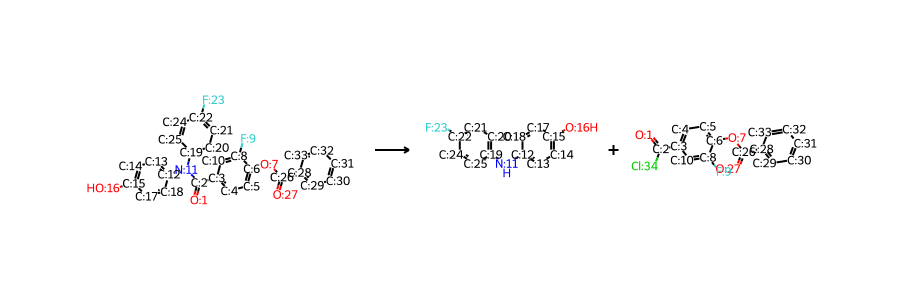

precursor mols: {'smiles': 'Oc1ccc(Nc2ccc(F)cc2)cc1', 'in_stock': False}
precursor mols: {'smiles': 'O=C(Cl)c1ccc(OC(=O)c2ccccc2)c(F)c1', 'in_stock': False}
 
 
seq3, reaction 4 data:

target smiles: O=C(Cl)c1ccc(OC(=O)c2ccccc2)c(F)c1
library_occurence: 2874
template: [Cl;H0;D1;+0:1]-[C;H0;D3;+0:2](=[O;D1;H0:3])-[c:4]>>Cl-S(=O)-[Cl;H0;D1;+0:1].O-[C;H0;D3;+0:2](=[O;D1;H0:3])-[c:4]


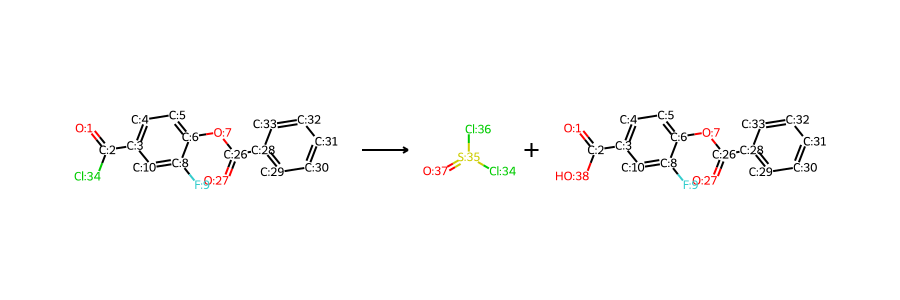

precursor mols: {'smiles': 'O=S(Cl)Cl', 'in_stock': True}
precursor mols: {'smiles': 'O=C(O)c1ccc(OC(=O)c2ccccc2)c(F)c1', 'in_stock': False}
 
 
seq3, reaction 3 data:

target smiles: O=C(O)c1ccc(OC(=O)c2ccccc2)c(F)c1
library_occurence: 455
template: [O;D1;H0:2]=[C;H0;D3;+0:1](-[c:3])-[O;H0;D2;+0:4]-[c:5]>>Cl-[C;H0;D3;+0:1](=[O;D1;H0:2])-[c:3].[OH;D1;+0:4]-[c:5]


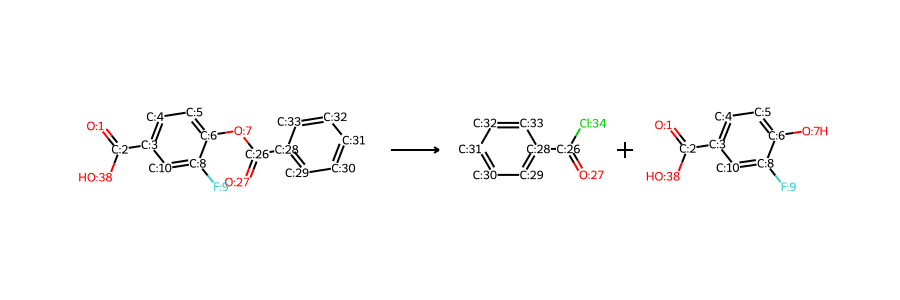

precursor mols: {'smiles': 'O=C(Cl)c1ccccc1', 'in_stock': True}
precursor mols: {'smiles': 'O=C(O)c1ccc(O)c(F)c1', 'in_stock': True}
 
 
seq3, reaction 2 data:

target smiles: Oc1ccc(Nc2ccc(F)cc2)cc1
library_occurence: 333
template: [#7:1]-[c:2]1:[c:3]:[c:4]:[c:5](-[OH;D1;+0:6]):[c:7]:[c:8]:1>>[#7:1]-[c:2]1:[c:3]:[c:4]:[c:5](-[O;H0;D2;+0:6]-C-c2:c:c:c:c:c:2):[c:7]:[c:8]:1


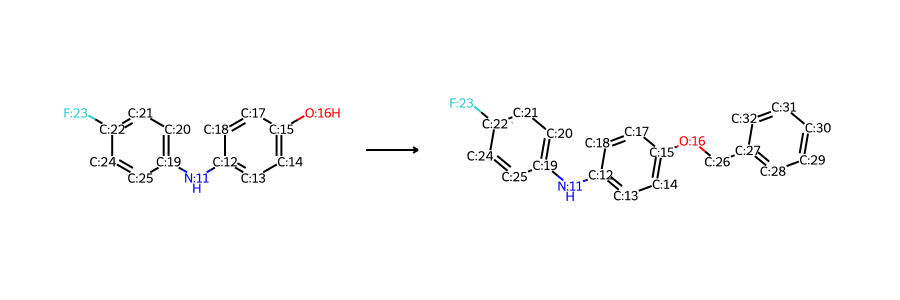

precursor mols: {'smiles': 'Fc1ccc(Nc2ccc(OCc3ccccc3)cc2)cc1', 'in_stock': False}
 
 
seq3, reaction 1 data:

target smiles: Fc1ccc(Nc2ccc(OCc3ccccc3)cc2)cc1
library_occurence: 772
template: [c:2]:[c;H0;D3;+0:1](:[c:3])-[NH;D2;+0:4]-[c:5]>>Br-[c;H0;D3;+0:1](:[c:2]):[c:3].[NH2;D1;+0:4]-[c:5]


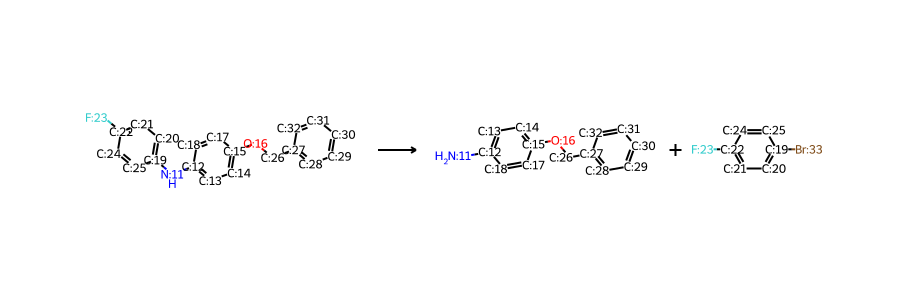

precursor mols: {'smiles': 'Nc1ccc(OCc2ccccc2)cc1', 'in_stock': True}
precursor mols: {'smiles': 'Fc1ccc(Br)cc1', 'in_stock': True}
 
 
--------------------------------------------



seq4
state_score 0.9634470710684997
Target smiles: O=C(c1ccc(O)c(F)c1)N(c1ccc(O)cc1)c1ccc(F)cc1, in_stock': False
 
seq4, reaction 5 data:

target smiles: O=C(c1ccc(O)c(F)c1)N(c1ccc(O)cc1)c1ccc(F)cc1
library_occurence: 137
template: [OH;D1;+0:1]-[c;H0;D3;+0:2](:[c:3]):[c:4]>>[O;H0;D1;+0:1]=C-[c;H0;D3;+0:2](:[c:3]):[c:4]


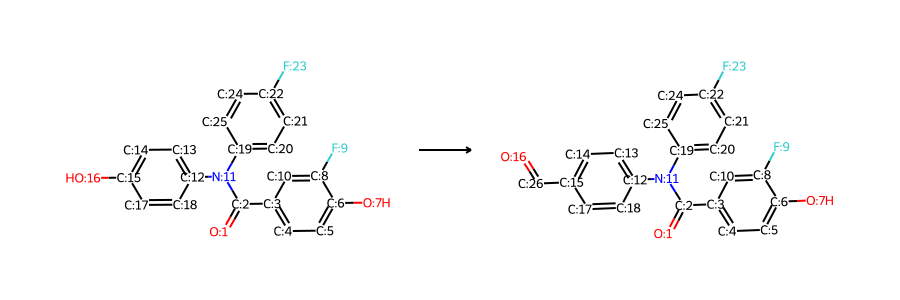

precursor mols: {'smiles': 'O=Cc1ccc(N(C(=O)c2ccc(O)c(F)c2)c2ccc(F)cc2)cc1', 'in_stock': False}
 
 
seq4, reaction 4 data:

target smiles: O=Cc1ccc(N(C(=O)c2ccc(O)c(F)c2)c2ccc(F)cc2)cc1
library_occurence: 1138
template: [O;D1;H0:2]=[CH;D2;+0:1]-[c;H0;D3;+0:4](:[c:3]):[c:5]>>C-N(-C)-[CH;D2;+0:1]=[O;D1;H0:2].[c:3]:[cH;D2;+0:4]:[c:5]


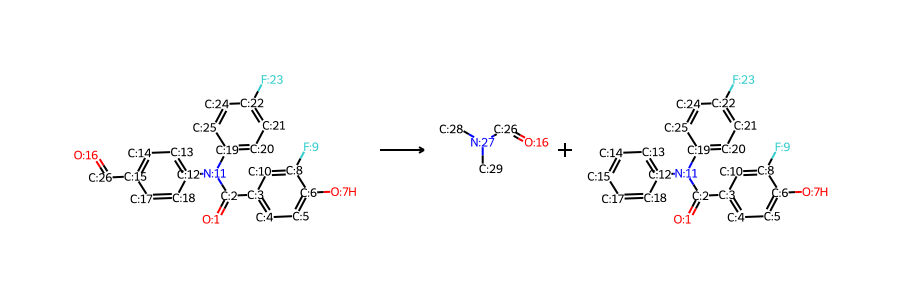

precursor mols: {'smiles': 'CN(C)C=O', 'in_stock': True}
precursor mols: {'smiles': 'O=C(c1ccc(O)c(F)c1)N(c1ccccc1)c1ccc(F)cc1', 'in_stock': False}
 
 
seq4, reaction 3 data:

target smiles: O=C(c1ccc(O)c(F)c1)N(c1ccccc1)c1ccc(F)cc1
library_occurence: 284
template: [#7:7]-[C:6](=[O;D1;H0:8])-[c:5]1:[c:4]:[c:3]:[c:2](-[OH;D1;+0:1]):[c:10]:[c:9]:1>>C-[O;H0;D2;+0:1]-[c:2]1:[c:3]:[c:4]:[c:5](-[C:6](-[#7:7])=[O;D1;H0:8]):[c:9]:[c:10]:1


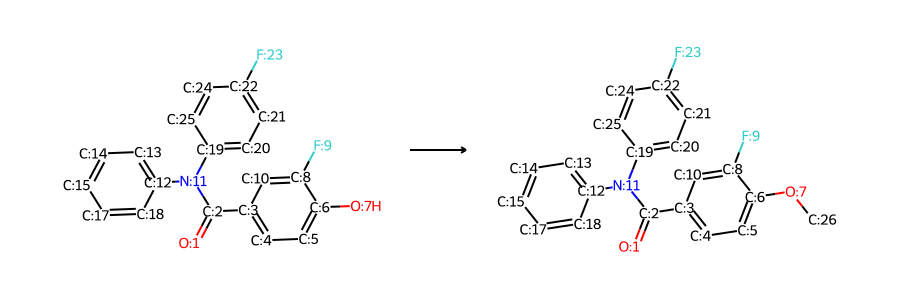

precursor mols: {'smiles': 'COc1ccc(C(=O)N(c2ccccc2)c2ccc(F)cc2)cc1F', 'in_stock': False}
 
 
seq4, reaction 2 data:

target smiles: COc1ccc(C(=O)N(c2ccccc2)c2ccc(F)cc2)cc1F
library_occurence: 16
template: [O;D1;H0:2]=[C;H0;D3;+0:1](-[c:3])-[N;H0;D3;+0:5](-[c:4])-[c:6]>>Cl-[C;H0;D3;+0:1](=[O;D1;H0:2])-[c:3].[c:4]-[NH;D2;+0:5]-[c:6]


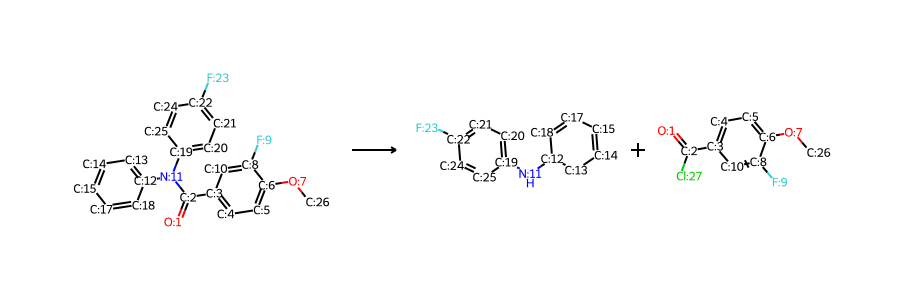

precursor mols: {'smiles': 'Fc1ccc(Nc2ccccc2)cc1', 'in_stock': False}
precursor mols: {'smiles': 'COc1ccc(C(=O)Cl)cc1F', 'in_stock': True}
 
 
seq4, reaction 1 data:

target smiles: Fc1ccc(Nc2ccccc2)cc1
library_occurence: 772
template: [c:2]:[c;H0;D3;+0:1](:[c:3])-[NH;D2;+0:4]-[c:5]>>Br-[c;H0;D3;+0:1](:[c:2]):[c:3].[NH2;D1;+0:4]-[c:5]


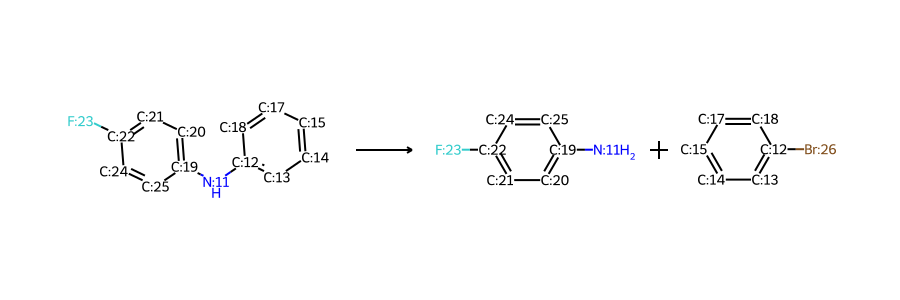

precursor mols: {'smiles': 'Nc1ccc(F)cc1', 'in_stock': True}
precursor mols: {'smiles': 'Brc1ccccc1', 'in_stock': True}
 
 
--------------------------------------------



seq5
state_score 0.9634470710684997
Target smiles: O=C(c1ccc(O)c(F)c1)N(c1ccc(O)cc1)c1ccc(F)cc1, in_stock': False
 
seq5, reaction 5 data:

target smiles: O=C(c1ccc(O)c(F)c1)N(c1ccc(O)cc1)c1ccc(F)cc1
library_occurence: 137
template: [OH;D1;+0:1]-[c;H0;D3;+0:2](:[c:3]):[c:4]>>[O;H0;D1;+0:1]=C-[c;H0;D3;+0:2](:[c:3]):[c:4]


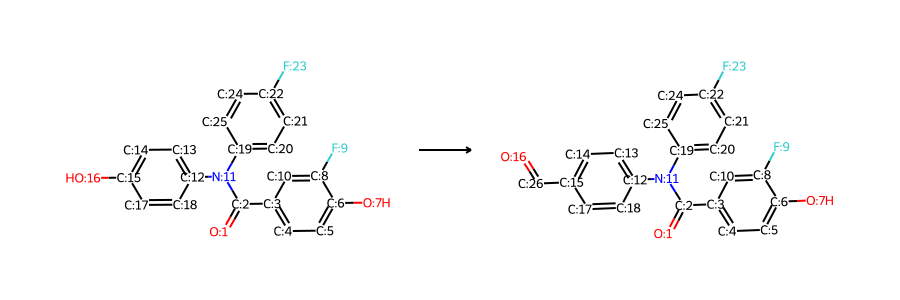

precursor mols: {'smiles': 'O=Cc1ccc(N(C(=O)c2ccc(O)c(F)c2)c2ccc(F)cc2)cc1', 'in_stock': False}
 
 
seq5, reaction 4 data:

target smiles: O=Cc1ccc(N(C(=O)c2ccc(O)c(F)c2)c2ccc(F)cc2)cc1
library_occurence: 1138
template: [O;D1;H0:2]=[CH;D2;+0:1]-[c;H0;D3;+0:4](:[c:3]):[c:5]>>C-N(-C)-[CH;D2;+0:1]=[O;D1;H0:2].[c:3]:[cH;D2;+0:4]:[c:5]


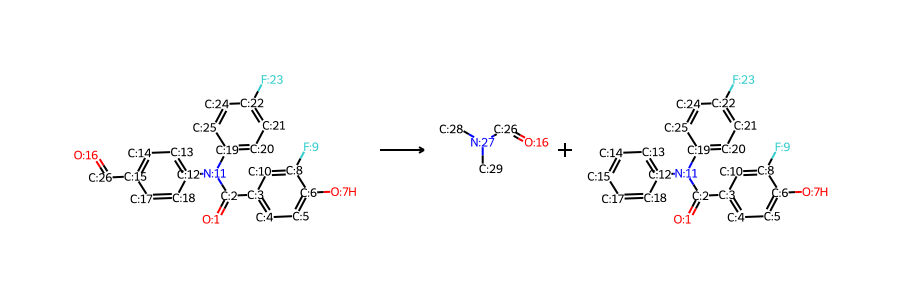

precursor mols: {'smiles': 'CN(C)C=O', 'in_stock': True}
precursor mols: {'smiles': 'O=C(c1ccc(O)c(F)c1)N(c1ccccc1)c1ccc(F)cc1', 'in_stock': False}
 
 
seq5, reaction 3 data:

target smiles: O=C(c1ccc(O)c(F)c1)N(c1ccccc1)c1ccc(F)cc1
library_occurence: 284
template: [#7:7]-[C:6](=[O;D1;H0:8])-[c:5]1:[c:4]:[c:3]:[c:2](-[OH;D1;+0:1]):[c:10]:[c:9]:1>>C-[O;H0;D2;+0:1]-[c:2]1:[c:3]:[c:4]:[c:5](-[C:6](-[#7:7])=[O;D1;H0:8]):[c:9]:[c:10]:1


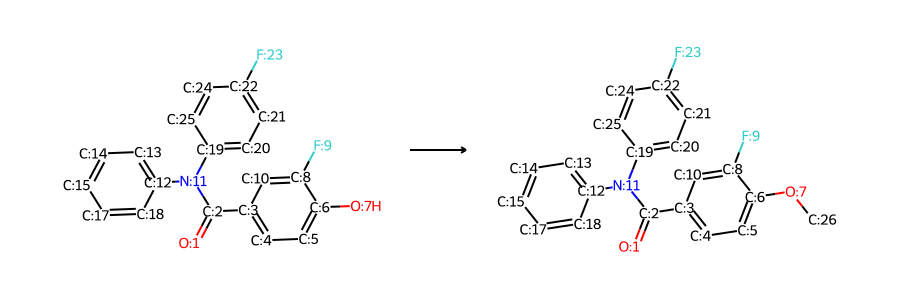

precursor mols: {'smiles': 'COc1ccc(C(=O)N(c2ccccc2)c2ccc(F)cc2)cc1F', 'in_stock': False}
 
 
seq5, reaction 2 data:

target smiles: COc1ccc(C(=O)N(c2ccccc2)c2ccc(F)cc2)cc1F
library_occurence: 16
template: [O;D1;H0:2]=[C;H0;D3;+0:1](-[c:3])-[N;H0;D3;+0:5](-[c:4])-[c:6]>>Cl-[C;H0;D3;+0:1](=[O;D1;H0:2])-[c:3].[c:4]-[NH;D2;+0:5]-[c:6]


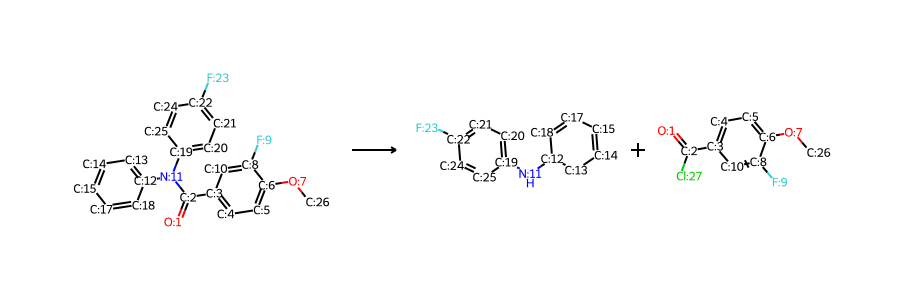

precursor mols: {'smiles': 'Fc1ccc(Nc2ccccc2)cc1', 'in_stock': False}
precursor mols: {'smiles': 'COc1ccc(C(=O)Cl)cc1F', 'in_stock': True}
 
 
seq5, reaction 1 data:

target smiles: Fc1ccc(Nc2ccccc2)cc1
library_occurence: 772
template: [c:2]:[c;H0;D3;+0:1](:[c:3])-[NH;D2;+0:4]-[c:5]>>Br-[c;H0;D3;+0:1](:[c:2]):[c:3].[NH2;D1;+0:4]-[c:5]


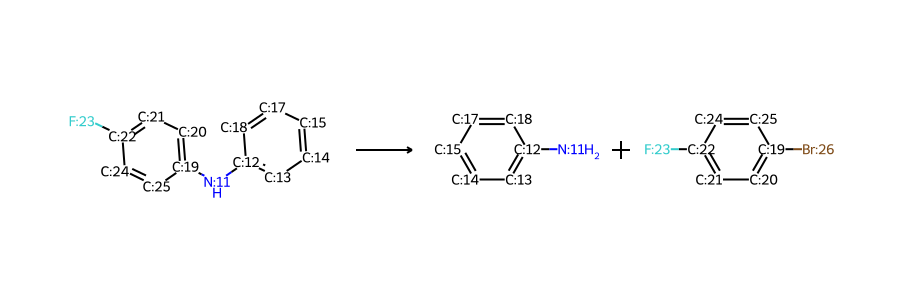

precursor mols: {'smiles': 'Nc1ccccc1', 'in_stock': True}
precursor mols: {'smiles': 'Fc1ccc(Br)cc1', 'in_stock': True}
 
 
--------------------------------------------



seq6
state_score 0.9634470710684997
Target smiles: O=C(c1ccc(O)c(F)c1)N(c1ccc(O)cc1)c1ccc(F)cc1, in_stock': False
 
seq6, reaction 7 data:

target smiles: O=C(c1ccc(O)c(F)c1)N(c1ccc(O)cc1)c1ccc(F)cc1
library_occurence: 111
template: [OH;D1;+0:1]-[c:2]>>O=C(-[O;H0;D2;+0:1]-[c:2])-c1:c:c:c:c:c:1


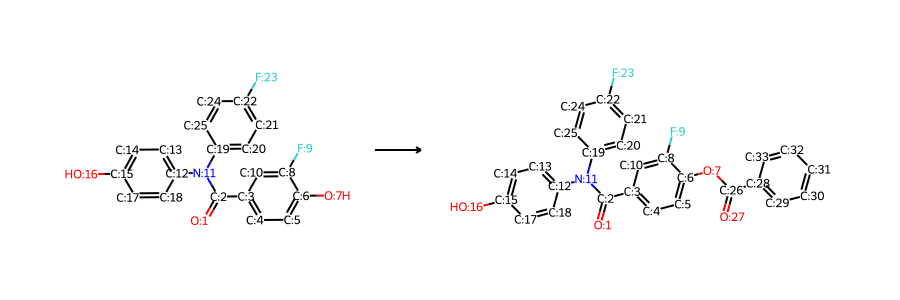

precursor mols: {'smiles': 'O=C(Oc1ccc(C(=O)N(c2ccc(O)cc2)c2ccc(F)cc2)cc1F)c1ccccc1', 'in_stock': False}
 
 
seq6, reaction 6 data:

target smiles: O=C(Oc1ccc(C(=O)N(c2ccc(O)cc2)c2ccc(F)cc2)cc1F)c1ccccc1
library_occurence: 16
template: [O;D1;H0:2]=[C;H0;D3;+0:1](-[c:3])-[N;H0;D3;+0:5](-[c:4])-[c:6]>>Cl-[C;H0;D3;+0:1](=[O;D1;H0:2])-[c:3].[c:4]-[NH;D2;+0:5]-[c:6]


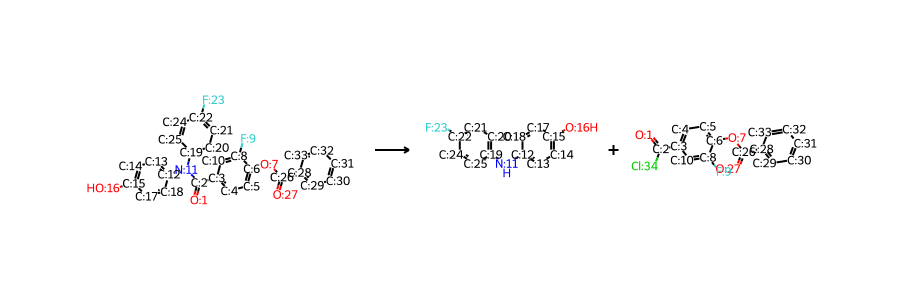

precursor mols: {'smiles': 'Oc1ccc(Nc2ccc(F)cc2)cc1', 'in_stock': False}
precursor mols: {'smiles': 'O=C(Cl)c1ccc(OC(=O)c2ccccc2)c(F)c1', 'in_stock': False}
 
 
seq6, reaction 5 data:

target smiles: O=C(Cl)c1ccc(OC(=O)c2ccccc2)c(F)c1
library_occurence: 2874
template: [Cl;H0;D1;+0:1]-[C;H0;D3;+0:2](=[O;D1;H0:3])-[c:4]>>Cl-S(=O)-[Cl;H0;D1;+0:1].O-[C;H0;D3;+0:2](=[O;D1;H0:3])-[c:4]


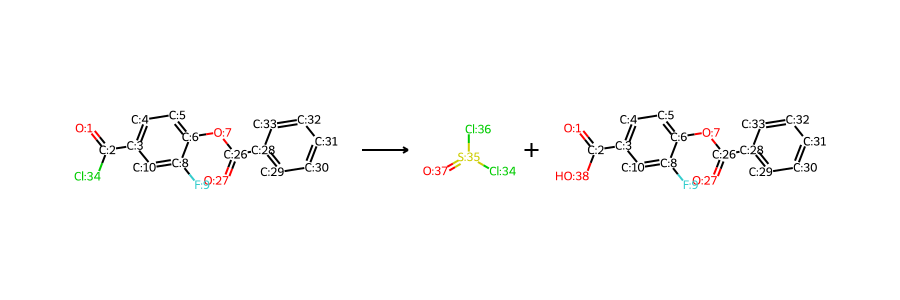

precursor mols: {'smiles': 'O=S(Cl)Cl', 'in_stock': True}
precursor mols: {'smiles': 'O=C(O)c1ccc(OC(=O)c2ccccc2)c(F)c1', 'in_stock': False}
 
 
seq6, reaction 4 data:

target smiles: O=C(O)c1ccc(OC(=O)c2ccccc2)c(F)c1
library_occurence: 455
template: [O;D1;H0:2]=[C;H0;D3;+0:1](-[c:3])-[O;H0;D2;+0:4]-[c:5]>>Cl-[C;H0;D3;+0:1](=[O;D1;H0:2])-[c:3].[OH;D1;+0:4]-[c:5]


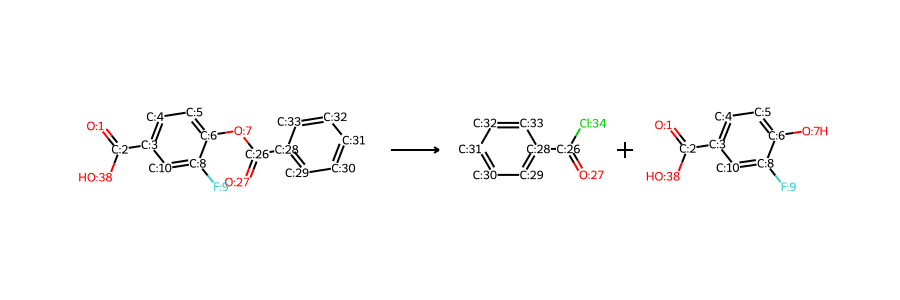

precursor mols: {'smiles': 'O=C(Cl)c1ccccc1', 'in_stock': True}
precursor mols: {'smiles': 'O=C(O)c1ccc(O)c(F)c1', 'in_stock': True}
 
 
seq6, reaction 3 data:

target smiles: Oc1ccc(Nc2ccc(F)cc2)cc1
library_occurence: 333
template: [#7:1]-[c:2]1:[c:3]:[c:4]:[c:5](-[OH;D1;+0:6]):[c:7]:[c:8]:1>>[#7:1]-[c:2]1:[c:3]:[c:4]:[c:5](-[O;H0;D2;+0:6]-C-c2:c:c:c:c:c:2):[c:7]:[c:8]:1


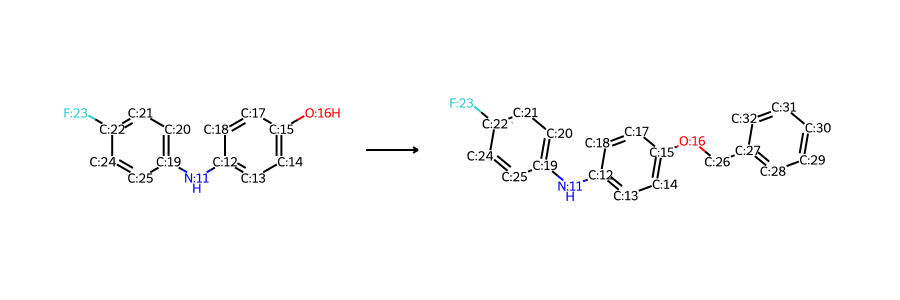

precursor mols: {'smiles': 'Fc1ccc(Nc2ccc(OCc3ccccc3)cc2)cc1', 'in_stock': False}
 
 
seq6, reaction 2 data:

target smiles: Fc1ccc(Nc2ccc(OCc3ccccc3)cc2)cc1
library_occurence: 772
template: [c:2]:[c;H0;D3;+0:1](:[c:3])-[NH;D2;+0:4]-[c:5]>>Br-[c;H0;D3;+0:1](:[c:2]):[c:3].[NH2;D1;+0:4]-[c:5]


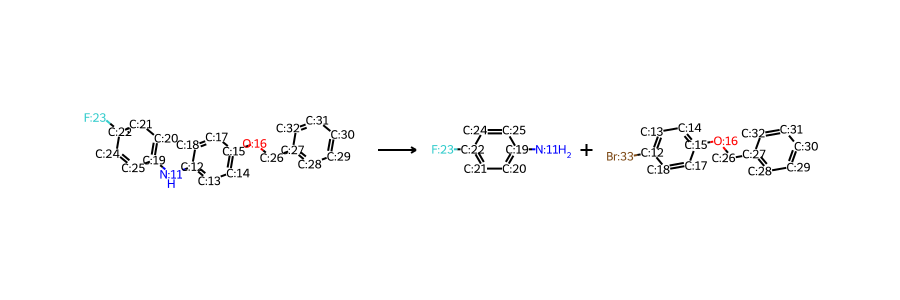

precursor mols: {'smiles': 'Nc1ccc(F)cc1', 'in_stock': True}
precursor mols: {'smiles': 'Brc1ccc(OCc2ccccc2)cc1', 'in_stock': False}
 
 
seq6, reaction 1 data:

target smiles: Brc1ccc(OCc2ccccc2)cc1
library_occurence: 5146
template: [c:4]-[O;H0;D2;+0:3]-[CH2;D2;+0:1]-[c:2]>>Br-[CH2;D2;+0:1]-[c:2].[OH;D1;+0:3]-[c:4]


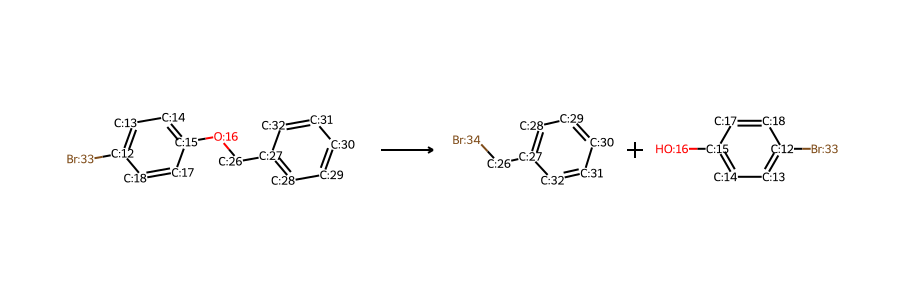

precursor mols: {'smiles': 'BrCc1ccccc1', 'in_stock': True}
precursor mols: {'smiles': 'Oc1ccc(Br)cc1', 'in_stock': True}
 
 
--------------------------------------------





In [38]:
# Now we can depict the reactions with RDKit.
from rdkit.Chem import rdChemReactions
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import SVG

for key,value in all_sequences_data2.items():
    print(str(key))
    print("state_score " + str(value["state_score"]))
    print("Target smiles: " + str(value['target_smiles']) + ", in_stock': " + str(value["in_stock"]))
    print(" ")
    
    total_reactions = len(value['list_of_reactions'])
    for i, reaction in enumerate(value['list_of_reactions']):
        rxn_num = total_reactions - i # reverse rxn numbers
        print(str(key) + ", reaction " + str(rxn_num) +  " data:\n")
        print("target smiles: " + reaction["rxn_target_smiles"])
        print("library_occurence: " + str(reaction["library_occurence"]))
        print("template: " + reaction["template"])

        # Draw reaction with RDKit using rdMolDraw2D module
        rxn_smiles = reaction["mapped_reaction_smiles"]
        rxn = rdChemReactions.ReactionFromSmarts(rxn_smiles,useSmiles=True)
        rdChemReactions.SanitizeRxn(rxn)
        drawer = rdMolDraw2D.MolDraw2DSVG(900,300)
        drawer.drawOptions().addStereoAnnotation = False
        drawer.DrawReaction(rxn,highlightByReactant=False)
        drawer.FinishDrawing()
        display(SVG(drawer.GetDrawingText()))

        for smiles in reaction['mol_children']:
            print("precursor mols: " + str(smiles))
        print(" ")
        print(" ")

    print('--------------------------------------------\n\n\n')

In [39]:
# If you want the retrosynthesis arrow instead,
# we can do that!
os.chdir('..')
os.chdir('../X_Extras')

# Import the retro arrow functions
from draw_retro import create_rxn_svg, add_retro_arrow

In [40]:
all_sequences_data2.keys()

dict_keys(['seq0', 'seq1', 'seq2', 'seq3', 'seq4', 'seq5', 'seq6'])

seq4
state_score 0.9634470710684997
Target smiles: O=C(c1ccc(O)c(F)c1)N(c1ccc(O)cc1)c1ccc(F)cc1, in_stock': False
 
seq4, reaction 5 data:

target smiles: O=C(c1ccc(O)c(F)c1)N(c1ccc(O)cc1)c1ccc(F)cc1
library_occurence: 137
template: [OH;D1;+0:1]-[c;H0;D3;+0:2](:[c:3]):[c:4]>>[O;H0;D1;+0:1]=C-[c;H0;D3;+0:2](:[c:3]):[c:4]


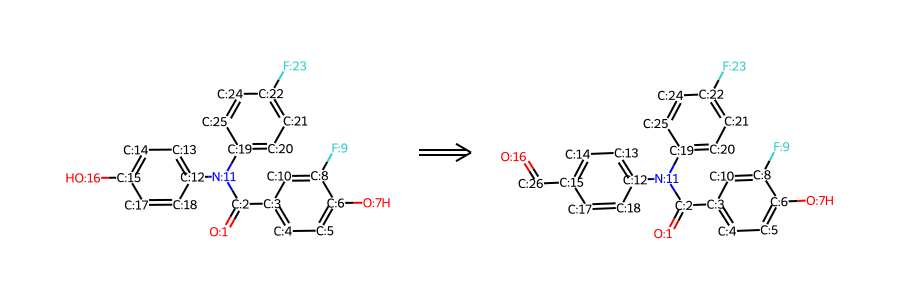

precursor mols: {'smiles': 'O=Cc1ccc(N(C(=O)c2ccc(O)c(F)c2)c2ccc(F)cc2)cc1', 'in_stock': False}
 
 
seq4, reaction 4 data:

target smiles: O=Cc1ccc(N(C(=O)c2ccc(O)c(F)c2)c2ccc(F)cc2)cc1
library_occurence: 1138
template: [O;D1;H0:2]=[CH;D2;+0:1]-[c;H0;D3;+0:4](:[c:3]):[c:5]>>C-N(-C)-[CH;D2;+0:1]=[O;D1;H0:2].[c:3]:[cH;D2;+0:4]:[c:5]


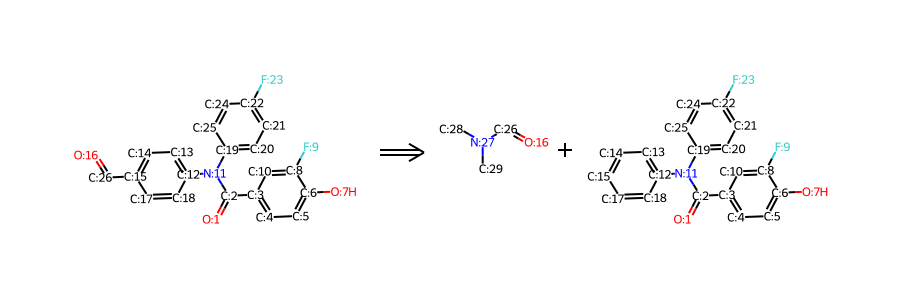

precursor mols: {'smiles': 'CN(C)C=O', 'in_stock': True}
precursor mols: {'smiles': 'O=C(c1ccc(O)c(F)c1)N(c1ccccc1)c1ccc(F)cc1', 'in_stock': False}
 
 
seq4, reaction 3 data:

target smiles: O=C(c1ccc(O)c(F)c1)N(c1ccccc1)c1ccc(F)cc1
library_occurence: 284
template: [#7:7]-[C:6](=[O;D1;H0:8])-[c:5]1:[c:4]:[c:3]:[c:2](-[OH;D1;+0:1]):[c:10]:[c:9]:1>>C-[O;H0;D2;+0:1]-[c:2]1:[c:3]:[c:4]:[c:5](-[C:6](-[#7:7])=[O;D1;H0:8]):[c:9]:[c:10]:1


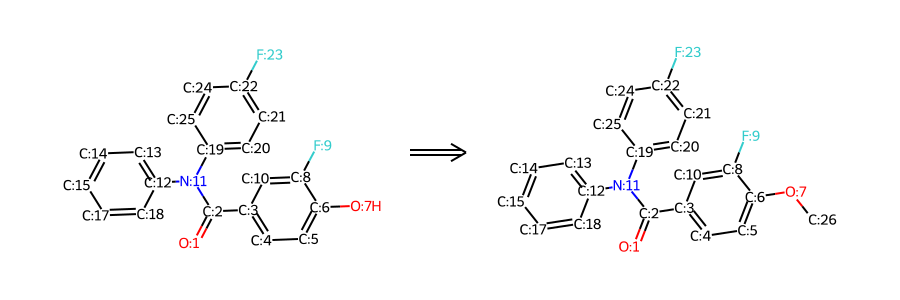

precursor mols: {'smiles': 'COc1ccc(C(=O)N(c2ccccc2)c2ccc(F)cc2)cc1F', 'in_stock': False}
 
 
seq4, reaction 2 data:

target smiles: COc1ccc(C(=O)N(c2ccccc2)c2ccc(F)cc2)cc1F
library_occurence: 16
template: [O;D1;H0:2]=[C;H0;D3;+0:1](-[c:3])-[N;H0;D3;+0:5](-[c:4])-[c:6]>>Cl-[C;H0;D3;+0:1](=[O;D1;H0:2])-[c:3].[c:4]-[NH;D2;+0:5]-[c:6]


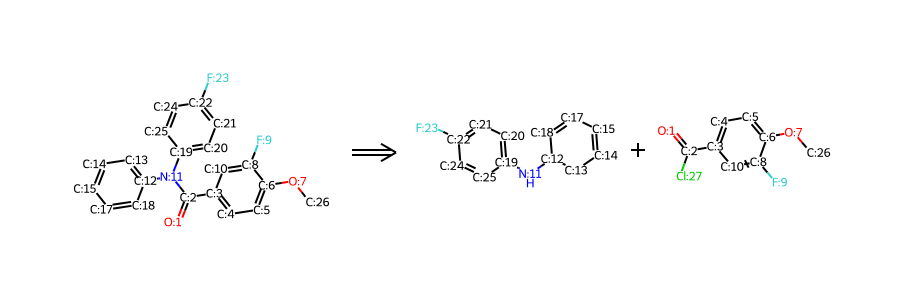

precursor mols: {'smiles': 'Fc1ccc(Nc2ccccc2)cc1', 'in_stock': False}
precursor mols: {'smiles': 'COc1ccc(C(=O)Cl)cc1F', 'in_stock': True}
 
 
seq4, reaction 1 data:

target smiles: Fc1ccc(Nc2ccccc2)cc1
library_occurence: 772
template: [c:2]:[c;H0;D3;+0:1](:[c:3])-[NH;D2;+0:4]-[c:5]>>Br-[c;H0;D3;+0:1](:[c:2]):[c:3].[NH2;D1;+0:4]-[c:5]


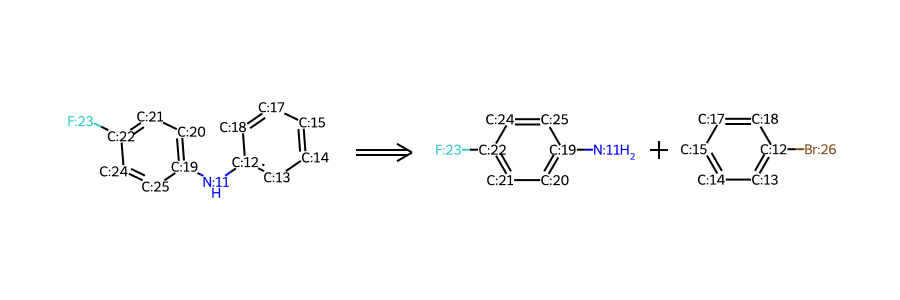

precursor mols: {'smiles': 'Nc1ccc(F)cc1', 'in_stock': True}
precursor mols: {'smiles': 'Brc1ccccc1', 'in_stock': True}
 
 
--------------------------------------------





In [41]:
for key,value in all_sequences_data2.items():
    if key == 'seq4': # for testing, just look at sequence 4
       print(str(key))
       print("state_score " + str(value["state_score"]))
       print("Target smiles: " + str(value["target_smiles"]) + ", in_stock': " + str(value["in_stock"]))
       print(" ")

       total_reactions = len(value['list_of_reactions'])
       for i, reaction in enumerate(value['list_of_reactions']):
           rxn_num = total_reactions - i # reverse rxn numbers
           
           print(str(key) + ", reaction " + str(rxn_num) +  " data:\n")
           print("target smiles: " + reaction["rxn_target_smiles"])
           print("library_occurence: " + str(reaction["library_occurence"]))
           print("template: " + reaction["template"])

           # Draw reaction with RDKit using retro arrow hack
           rxn_smiles = reaction["mapped_reaction_smiles"]
           rxn = rdChemReactions.ReactionFromSmarts(rxn_smiles,useSmiles=True)
           rdChemReactions.SanitizeRxn(rxn)

           rxn_svg = create_rxn_svg(rxn, 900, 300)
           display(SVG(add_retro_arrow(rxn_svg)))

           for smiles in reaction['mol_children']:
               print("precursor mols: " + str(smiles))
           print(" ")
           print(" ")

       print('--------------------------------------------\n\n\n')

In [42]:
# Finally, since we saved the templates, let's take a quick look at one
# Get data foe Seq4
sequence4 = all_sequences_data2['seq4']
sequence4

{'target_smiles': 'O=C(c1ccc(O)c(F)c1)N(c1ccc(O)cc1)c1ccc(F)cc1',
 'in_stock': False,
 'state_score': 0.9634470710684997,
 'list_of_reactions': [{'rxn_target_smiles': 'O=C(c1ccc(O)c(F)c1)N(c1ccc(O)cc1)c1ccc(F)cc1',
   'library_occurence': 137,
   'template': '[OH;D1;+0:1]-[c;H0;D3;+0:2](:[c:3]):[c:4]>>[O;H0;D1;+0:1]=C-[c;H0;D3;+0:2](:[c:3]):[c:4]',
   'mapped_reaction_smiles': '[O:1]=[C:2]([c:3]1[cH:4][cH:5][c:6]([OH:7])[c:8]([F:9])[cH:10]1)[N:11]([c:12]1[cH:13][cH:14][c:15]([OH:16])[cH:17][cH:18]1)[c:19]1[cH:20][cH:21][c:22]([F:23])[cH:24][cH:25]1>>[O:1]=[C:2]([c:3]1[cH:4][cH:5][c:6]([OH:7])[c:8]([F:9])[cH:10]1)[N:11]([c:12]1[cH:13][cH:14][c:15]([CH:26]=[O:16])[cH:17][cH:18]1)[c:19]1[cH:20][cH:21][c:22]([F:23])[cH:24][cH:25]1',
   'mol_children': [{'smiles': 'O=Cc1ccc(N(C(=O)c2ccc(O)c(F)c2)c2ccc(F)cc2)cc1',
     'in_stock': False}]},
  {'rxn_target_smiles': 'O=Cc1ccc(N(C(=O)c2ccc(O)c(F)c2)c2ccc(F)cc2)cc1',
   'library_occurence': 1138,
   'template': '[O;D1;H0:2]=[CH;D2;+0:1]-[c;H0;D3

In [43]:
# get the last rxn, which is the one depicted right above this
sequence4['list_of_reactions'][-1]

{'rxn_target_smiles': 'Fc1ccc(Nc2ccccc2)cc1',
 'library_occurence': 772,
 'template': '[c:2]:[c;H0;D3;+0:1](:[c:3])-[NH;D2;+0:4]-[c:5]>>Br-[c;H0;D3;+0:1](:[c:2]):[c:3].[NH2;D1;+0:4]-[c:5]',
 'mapped_reaction_smiles': '[NH:11]([c:12]1[cH:13][cH:14][cH:15][cH:17][cH:18]1)[c:19]1[cH:20][cH:21][c:22]([F:23])[cH:24][cH:25]1>>[NH2:11][c:19]1[cH:20][cH:21][c:22]([F:23])[cH:24][cH:25]1.[c:12]1([Br:26])[cH:13][cH:14][cH:15][cH:17][cH:18]1',
 'mol_children': [{'smiles': 'Nc1ccc(F)cc1', 'in_stock': True},
  {'smiles': 'Brc1ccccc1', 'in_stock': True}]}

In [44]:
# Get template and the rxn target smiles
template = sequence4['list_of_reactions'][-1]["template"]
template

'[c:2]:[c;H0;D3;+0:1](:[c:3])-[NH;D2;+0:4]-[c:5]>>Br-[c;H0;D3;+0:1](:[c:2]):[c:3].[NH2;D1;+0:4]-[c:5]'

In [45]:
rxn_target_smiles = sequence4['list_of_reactions'][-1]["rxn_target_smiles"]
rxn_target_smiles

'Fc1ccc(Nc2ccccc2)cc1'

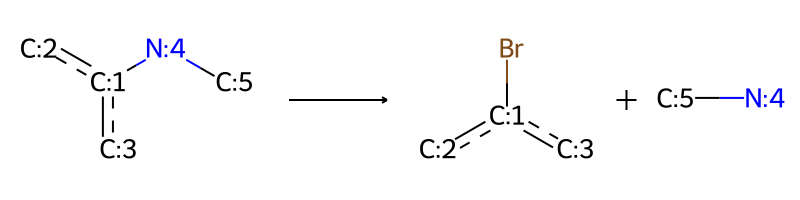

In [46]:
rxn = rdChemReactions.ReactionFromSmarts(template)
rdChemReactions.SanitizeRxn(rxn)
rxn

In [47]:
rxn.GetNumProductTemplates()

2

In [48]:
# Let's see if we get the same result as AiZynthFinder
from rdkit import Chem
product_tuples = rxn.RunReactants((Chem.MolFromSmiles(rxn_target_smiles),)) # need to input reactants as tuples (in this case, only 1)

# there can be several possible reactant sets generated
product_tuples

((<rdkit.Chem.rdchem.Mol at 0x41a3a5690>,
  <rdkit.Chem.rdchem.Mol at 0x41a3a57e0>),
 (<rdkit.Chem.rdchem.Mol at 0x41a3a5850>,
  <rdkit.Chem.rdchem.Mol at 0x41a3a58c0>),
 (<rdkit.Chem.rdchem.Mol at 0x41a3a5930>,
  <rdkit.Chem.rdchem.Mol at 0x41a3a59a0>),
 (<rdkit.Chem.rdchem.Mol at 0x41a3a5a10>,
  <rdkit.Chem.rdchem.Mol at 0x41a3a5a80>))

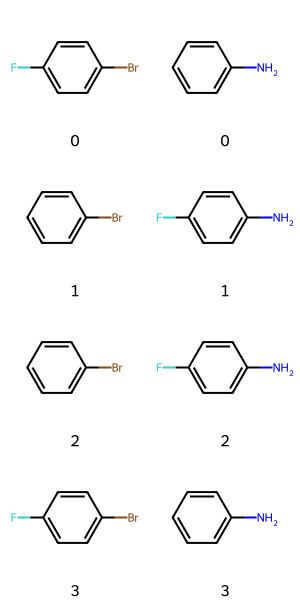

In [49]:
# Depict the reactant sets
def setup_grid(mols, num_molsPerRow=2, panel_size=150):
    molsPerRow = num_molsPerRow
    nRows = len(mols)//molsPerRow
    if len(mols)%molsPerRow:
       nRows+=1
    panelx = panel_size
    panely = panel_size
    canvasx = panelx * molsPerRow
    canvasy = panely * nRows
    drawer_grid = rdMolDraw2D.MolDraw2DCairo(canvasx,canvasy,panelx,panely)
    return drawer_grid

# PNG function
from PIL import Image
import io
# png function to view molecules
def show_png(drawing_text):

    # not sure why, but re-importing PIL
    # each time is necassary in Jupyter
    from PIL import Image
    import io
 
    bio = io.BytesIO(drawing_text)
    img = Image.open(bio)
    return img

# sanitize
product_san = []
for idx,product_set in enumerate(product_tuples):
    for product in product_set:
        Chem.SanitizeMol(product)
        product_san.append([idx, product])

# depict as a grid
mols = [item[1] for item in product_san]
labels = [str(item[0]) for item in product_san]
drawer = setup_grid(product_san, num_molsPerRow=2, panel_size=150)
drawer.DrawMolecules(mols, legends=labels)
drawer.FinishDrawing()
show_png(drawer.GetDrawingText())

In [50]:
# Check for matches to the AiZynthFinder prediction
# Get AiZynth precursor SMILES
ai_smi1 = sequence4['list_of_reactions'][-1]["mol_children"][0]['smiles']
ai_smi1

'Nc1ccc(F)cc1'

In [51]:
ai_smi2 = sequence4['list_of_reactions'][-1]["mol_children"][1]['smiles']
ai_smi2

'Brc1ccccc1'

In [52]:
# Canonicalize
aizynth_prediction = (Chem.MolToSmiles(Chem.MolFromSmiles(ai_smi1)), Chem.MolToSmiles(Chem.MolFromSmiles(ai_smi2)))
aizynth_prediction

('Nc1ccc(F)cc1', 'Brc1ccccc1')

In [53]:
# Now we can convert the rdkit reaction outputs to canonical SMILES
rdkit_products = []
for product_set in product_tuples:
    sanitized_products = []
    for product in product_set:
        Chem.SanitizeMol(product)
        sanitized_products.append(Chem.MolToSmiles(product))
    rdkit_products.append(tuple(sanitized_products))

rdkit_products

[('Fc1ccc(Br)cc1', 'Nc1ccccc1'),
 ('Brc1ccccc1', 'Nc1ccc(F)cc1'),
 ('Brc1ccccc1', 'Nc1ccc(F)cc1'),
 ('Fc1ccc(Br)cc1', 'Nc1ccccc1')]

In [54]:
# Loop through and see if there are any matches
sorted_aizynth_prediction = tuple(sorted(aizynth_prediction))
# Loop through the list and compare sorted tuples
matches = [tpl for tpl in rdkit_products if tuple(sorted(tpl)) == sorted_aizynth_prediction]

# Check if any matches were found
if matches:
    print("Match found:", matches)
else:
    print("No match found")

Match found: [('Brc1ccccc1', 'Nc1ccc(F)cc1'), ('Brc1ccccc1', 'Nc1ccc(F)cc1')]


## Bonus/Self-study Stuff Below

In [61]:
# Here is the aforementioned initial rxn tree parsing solution that uses recursion
# on the reaction tree dictionary output

# CID: 46861578
finder.target_smiles = "C1=CC(=CC=C1N(C2=CC=C(C=C2)F)C(=O)C3=CC(=C(C=C3)O)F)O"

# Perfrom the retro tree search
finder.tree_search()

# Build the routes
finder.build_routes()

# return trees as a list of python dictionaries
trees = finder.routes.dict_with_extra(include_scores=True,include_metadata=True)

In [ ]:
len(trees)

In [ ]:
# View first reaction path data
seq0 = trees[0]
seq0

In [ ]:
# Now let's experiment with indexing
# Extract state score
seq0['scores']['state score']

In [ ]:
# mapped_reaction_smiles
seq0['children'][0]['metadata']['mapped_reaction_smiles']

In [ ]:
# template
seq0['children'][0]['metadata']['template']

In [ ]:
# library occurance
seq0['children'][0]['metadata']['library_occurence']

In [ ]:
# reactants and stock status
for item in seq0['children'][0]['children']:
    print(item['smiles'], item['in_stock'])

In [ ]:
# Look at an example with more than 1 rxn
seq5 = trees[5]
seq5

In [ ]:
# Indexing becomes more challenging as there are nested children
# So it becomes a recursive exercise
# Here is the structure of the dictionary (seq5) without the values:
def print_dict(dictionary, indent = 0):
    for item in dictionary.items():
        print(" "*indent, item[0])
        if type(item[1]) is dict:
            print_dict(item[1], indent+4)
        if type(item[1]) is list:
            print_array(item[1], indent+4)

def print_array(array, indent = 0):
    for item in array:
        if type(item) is list:
            print_array(item, indent+4)
            continue
        if type(item) is dict:
            print_dict(item, indent+4)
            continue
        print(" "*indent, item)

print_dict(seq5)

In [71]:
# function to recursively traverses rxn tree structure
# ChatGPT4 adapted
def process_tree(node, sequence_dict, current_smiles):
    # If the current node is a reaction, process the reaction details
    if node['type'] == 'reaction':
        process_reaction(node, sequence_dict, current_smiles)
    
    # Recursively process each child node, passing down the current node's SMILES
    if 'children' in node:
        for child in node['children']:
            process_tree(child, sequence_dict, node['smiles'])

# function to extract and store data from the reactions
def process_reaction(node, sequence_dict, rxn_target_smiles):
    # Extract selected metadata from the reaction node
    template = node['metadata']['template']
    rxn_smiles = node['metadata']['mapped_reaction_smiles']
    library_occurence = node['metadata']['library_occurence']
    mol_children = []

    # Get information about the reactant molecules involved in the reaction
    for subitem in node['children']:
        if subitem['type'] == 'mol':
            mol_children.append({
                'smiles': subitem['smiles'],
                'in_stock': subitem['in_stock']
            })
    
    # Create a dictionary to store the reaction information
    reaction_info = {
        'rxn_target_smiles': rxn_target_smiles, # current node smiles being transformed
        'library_occurence': library_occurence,
        'template': template,
        'mapped_reaction_smiles': rxn_smiles,
        'mol_children': mol_children # reactant mols
    }

    # Add the reaction information to the list of reactions in the sequence dictionary
    sequence_dict.setdefault('list_of_reactions', []).append(reaction_info)

# Main processing loop, iterates over each rxn sequence in the tree
processed_trees_dict = {}
for i, sequence in enumerate(trees):
    # Initialize the dictionary to store sequence details and reactions
    sequence_dict = {
        'target_smiles': sequence['smiles'],
        'in_stock': sequence['in_stock'],
        'state_score': sequence['scores']['state score'],
        'list_of_reactions': []
    }
    # Process the tree sequence
    process_tree(sequence, sequence_dict, sequence['smiles'])

    # Store the processed sequence data in the final dictionary
    processed_trees_dict[f'seq{i}'] = sequence_dict

In [ ]:
processed_trees_dict

In [73]:
# Here is yet another solution to parsing the dictionary tree data that uses classes
# There are two classes, one for type Mols (targets/reactants) and then
# one for type Reactions. This will recursively go through the
# dictionary and extract out score, stock status,
# templates, and mapped reactions into a new dictionary.

class Mol:
    def __init__(self, mol_data):
        self.smiles = mol_data["smiles"]
        self.in_stock = mol_data["in_stock"]
        if "scores" in mol_data.keys():
            self.state_score = mol_data["scores"]["state score"]
        if "children" in mol_data.keys():
            new_reaction = mol_data["children"][0]
            self.reaction_child = Reaction(new_reaction)
        
class Reaction:
    def __init__(self, reaction_data):
        self.library_occurence = reaction_data["metadata"]["library_occurence"]
        self.template = reaction_data["metadata"]["template"]
        self.mapped_reaction_smiles = reaction_data["metadata"]["mapped_reaction_smiles"]
        self.mol_children = []
        for child in reaction_data["children"]:
            new_mol = Mol(child)
            self.mol_children.append(new_mol)

def get_proccess_dictionary(processed_tree_data):
    main_dict = {
        "smiles": processed_tree_data.smiles,
        "in_stock": processed_tree_data.in_stock,
        "state_score": processed_tree_data.state_score,
    }

    list_of_reactions = []
    process_reaction_child(processed_tree_data.smiles, processed_tree_data.reaction_child, list_of_reactions)
    main_dict["list_of_reactions"] = list_of_reactions
    return main_dict

def process_reaction_child(target_smile, reaction_child, list_of_reactions):
    reaction_data = {
        "target_smiles": target_smile,
        "library_occurence": reaction_child.library_occurence,
        "template": reaction_child.template,
        "mapped_reaction_smiles": reaction_child.mapped_reaction_smiles,
    }

    mol_children = []
    for child in reaction_child.mol_children:
        child_data = {
            "smiles": child.smiles,
            "in_stock": child.in_stock
        }
        mol_children.append(child_data)
    reaction_data["mol_children"] = mol_children
    list_of_reactions.append(reaction_data)

    for child in reaction_child.mol_children:
        if "reaction_child" in child.__dict__.keys():
            process_reaction_child(child.smiles, child.reaction_child, list_of_reactions)

In [74]:
processed_trees = [Mol(tree) for tree in trees]

In [ ]:
get_proccess_dictionary(processed_trees[0])